In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
threshold_for_results = 0.5

# RAM workable at 5% rescaled
#rescaled_size = (54,96)

# Grayscale has 1 dim (Can drop it)
# Width, Height
#input_shape = (200, 100)
#flatten_shape = (20000)

# RGB has 3 dims
input_shape = (None, 100, 200, 3)
flatten_shape = (None, 20000, 3)
flatten_value = 20000

print("Shape Ready")

Shape Ready


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020

from numpy.random import seed
seed(seed_value)

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_random_seed(seed_value)

print(tf.__version__)
print("Seed values re-set to 2019.")

1.15.0
Seed values re-set to 2019.


In [0]:
# Imports to read images
from matplotlib import pyplot as plt
#from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread
print("Import Done")

Import Done


In [0]:
# Imports for model building from tutorial site
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import cudnn_recurrent
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
print("Import Done")

Import Done


Using TensorFlow backend.


In [0]:
# Imports from previous model building
%matplotlib inline
import matplotlib.pyplot as plt
#import tensorflow as tf
#!pip install numpy==1.16.1
import numpy as np

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print(tf.__version__)
print("Import Done")

1.15.0
Import Done


In [0]:
# Imports for image downscaling because it takes too much RAM
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
print("Import Done")

Import Done


In [0]:
# Test code for rescaling
# Original Size = (200,100) Width, Height
# Total Images = 921

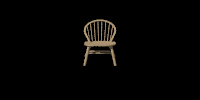

In [0]:
# Load first image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Scaled Pictures/ws_chair_scale001.png', grayscale=False)
image1

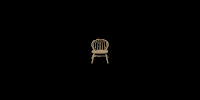

In [0]:
# Load last image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Scaled Pictures/ws_chair_scale921.png', grayscale=False)
image1

In [0]:
# Training Set
# To split the data to train 7 models, such that later models have more exposure to more data
# The pictures are NOT to be shuffled, the pictures are modified with increasing variance (in terms of scale)
# Model 1: Only the original unmodified image (001)
# Model 2: 001 ~ 185
# Model 3: 001 ~ 369
# Model 4: 001 ~ 553
# Model 5: 001 ~ 737
# Model 6: 001 ~ 911
# Model 7: 920 ~ 921

# Test Set
# All models are tested on the entire dataset of 921

In [0]:
# Data input
# Read in the training images
# Values are in RGB from 0 to 255, divide by 255 to get values from 0 to 1

train_image = []
for i in tqdm(range(1,922)):
    if i < 10:
      stringIndex = "00" + str(i)
    elif i < 100:
      stringIndex = "0" + str(i)
    else:
      stringIndex = str(i)

    # Parameter if needed: target_size = rescaled_size
    img = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Scaled Pictures/ws_chair_scale' + stringIndex + '.png', grayscale=False)

    img = image.img_to_array(img)
    img = img/255 
    train_image.append(img)

print(len(train_image))
#X = np.array(train_image) # wait for train face image below

100%|██████████| 921/921 [04:17<00:00,  3.58it/s]

921


In [0]:
X = np.array(train_image) # Transfer

# Create y values for training data
# All are 1s, since all are pictures of target chair
y = [1] * 921
y = np.asarray(y)

print(type(X))
print(X.shape)
print(len(X)) # Total length should be 921 training data

print(type(y))
print(y.shape)
print(len(y)) # Total length should be 921 training data


<class 'numpy.ndarray'>
(921, 100, 200, 3)
921
<class 'numpy.ndarray'>
(921,)
921


In [0]:
print(len(X))
print(X.shape)

print(len(y))
print(y.shape)

921
(921, 100, 200, 3)
921
(921,)


In [0]:
# Split into 6 portions, with the rest as validation sets
X_train1 = X[0:1]
X_train2 = X[0:185]
X_train3 = X[0:369]
X_train4 = X[0:553]
X_train5 = X[0:737]
X_train6 = X[0:911] # Remove last 10 images to set as validation
X_train7 = X[919:921] # Trained on the last 2 images only, the largest and smallest chair, most modified pictures

#X_train1 = X_train1.reshape(1,input_shape[0],input_shape[1], 3)
#X_train2 = X_train2.reshape(len(X_train2),input_shape[0],input_shape[1], 3)
#X_train3 = X_train3.reshape(len(X_train3),input_shape[0],input_shape[1], 3)
#X_train4 = X_train4.reshape(len(X_train4),input_shape[0],input_shape[1], 3)
#X_train5 = X_train5.reshape(len(X_train5),input_shape[0],input_shape[1], 3)
#X_train6 = X_train6.reshape(len(X_train6),input_shape[0],input_shape[1], 3)
#X_train7 = X_train7.reshape(len(X_train7),input_shape[0],input_shape[1], 3)

X_train1_flatten = X_train1.reshape(1,flatten_value, 3)
X_train2_flatten = X_train2.reshape(len(X_train2),flatten_value, 3)
X_train3_flatten = X_train3.reshape(len(X_train3),flatten_value, 3)
X_train4_flatten = X_train4.reshape(len(X_train4),flatten_value, 3)
X_train5_flatten = X_train5.reshape(len(X_train5),flatten_value, 3)
X_train6_flatten = X_train6.reshape(len(X_train6),flatten_value, 3)
X_train7_flatten = X_train7.reshape(len(X_train7),flatten_value, 3)

y_train1 = y[0:1]
y_train2 = y[0:185]
y_train3 = y[0:369]
y_train4 = y[0:553]
y_train5 = y[0:737]
y_train6 = y[0:911]
y_train7 = y[919:921]

X_val1 = X[1:921]
X_val2 = X[185:921]
X_val3 = X[369:921]
X_val4 = X[553:921]
X_val5 = X[737:921]
X_val6 = X[911:921]
X_val7 = X[0:919]

#X_val1 = X_val1.reshape(len(X_val1),input_shape[0],input_shape[1])
#X_val2 = X_val2.reshape(len(X_val2),input_shape[0],input_shape[1])
#X_val3 = X_val3.reshape(len(X_val3),input_shape[0],input_shape[1])
#X_val4 = X_val4.reshape(len(X_val4),input_shape[0],input_shape[1])
#X_val5 = X_val5.reshape(len(X_val5),input_shape[0],input_shape[1])
#X_val6 = X_val6.reshape(len(X_val6),input_shape[0],input_shape[1])
#X_val7 = X_val7.reshape(len(X_val7),input_shape[0],input_shape[1])

X_val1_flatten = X_val1.reshape(len(X_val1),flatten_value, 3)
X_val2_flatten = X_val2.reshape(len(X_val2),flatten_value, 3)
X_val3_flatten = X_val3.reshape(len(X_val3),flatten_value, 3)
X_val4_flatten = X_val4.reshape(len(X_val4),flatten_value, 3)
X_val5_flatten = X_val5.reshape(len(X_val5),flatten_value, 3)
X_val6_flatten = X_val6.reshape(len(X_val6),flatten_value, 3)
X_val7_flatten = X_val7.reshape(len(X_val7),flatten_value, 3)

y_val1 = y[1:921]
y_val2 = y[185:921]
y_val3 = y[369:921]
y_val4 = y[553:921]
y_val5 = y[737:921]
y_val6 = y[911:921]
y_val7 = y[0:919]

print("X Length")
print(len(X))

print("X Train Length")
print(len(X_train1))
print(len(X_train2))
print(len(X_train3))
print(len(X_train4))
print(len(X_train5))
print(len(X_train6))
print(len(X_train7))

print("X_train shape")
print(X_train1.shape)
print(X_train2.shape)
print(X_train3.shape)
print(X_train4.shape)
print(X_train5.shape)
print(X_train6.shape)
print(X_train7.shape)

print("X_train flatten")
print(X_train1_flatten.shape)
print(X_train2_flatten.shape)
print(X_train3_flatten.shape)
print(X_train4_flatten.shape)
print(X_train5_flatten.shape)
print(X_train6_flatten.shape)
print(X_train7_flatten.shape)

print("X_val shape")
print(X_val1.shape)
print(X_val2.shape)
print(X_val3.shape)
print(X_val4.shape)
print(X_val5.shape)
print(X_val6.shape)
print(X_val7.shape)

print("X_val flatten")
print(X_val1_flatten.shape)
print(X_val2_flatten.shape)
print(X_val3_flatten.shape)
print(X_val4_flatten.shape)
print(X_val5_flatten.shape)
print(X_val6_flatten.shape)
print(X_val7_flatten.shape)

print("Data Prepared")

X Length
921
X Train Length
1
185
369
553
737
911
2
X_train shape
(1, 100, 200, 3)
(185, 100, 200, 3)
(369, 100, 200, 3)
(553, 100, 200, 3)
(737, 100, 200, 3)
(911, 100, 200, 3)
(2, 100, 200, 3)
X_train flatten
(1, 20000, 3)
(185, 20000, 3)
(369, 20000, 3)
(553, 20000, 3)
(737, 20000, 3)
(911, 20000, 3)
(2, 20000, 3)
X_val shape
(920, 100, 200, 3)
(736, 100, 200, 3)
(552, 100, 200, 3)
(368, 100, 200, 3)
(184, 100, 200, 3)
(10, 100, 200, 3)
(919, 100, 200, 3)
X_val flatten
(920, 20000, 3)
(736, 20000, 3)
(552, 20000, 3)
(368, 20000, 3)
(184, 20000, 3)
(10, 20000, 3)
(919, 20000, 3)
Data Prepared


In [0]:
print("y_train")
print(y_train1.shape)
print(y_train2.shape)
print(y_train3.shape)
print(y_train4.shape)
print(y_train5.shape)
print(y_train6.shape)
print(y_train7.shape)

print("y_val")
print(y_val1.shape)
print(y_val2.shape)
print(y_val3.shape)
print(y_val4.shape)
print(y_val5.shape)
print(y_val6.shape)
print(y_val7.shape)

y_train
(1,)
(185,)
(369,)
(553,)
(737,)
(911,)
(2,)
y_val
(920,)
(736,)
(552,)
(368,)
(184,)
(10,)
(919,)


In [0]:
# Clear Variables no longer needed
train_image = None
X = None
y = None

In [0]:
###########################################################################################################################
#------------------------------------------------------------Model Building-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters
batch_size_user = 2
epoch_user = 1
times_to_loop_model = 3

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
2
1
3


In [0]:
###########################################################################################################################
#------------------------------------------------------------Dense Model-----------------------------------------------#
###########################################################################################################################





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1 samples, validate on 920 samples
Epoch 1/1





1/1 [==============================] - 11s 11s/step - loss: 0.6931 - a

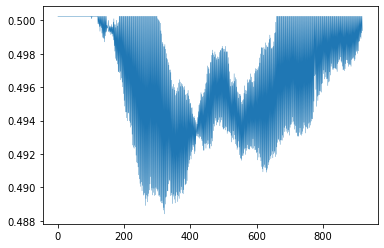

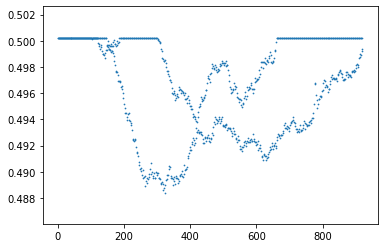

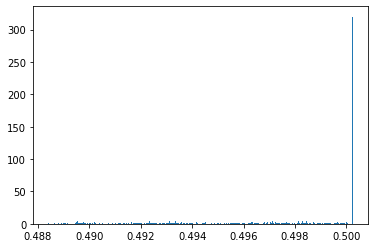

Average value is:  0.49668938
Total Predicted Positive:  520  out of  920
56.52173913043478 %
Epoch:  2
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 757ms/step - loss: 0.6926 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.3674
(920, 1)


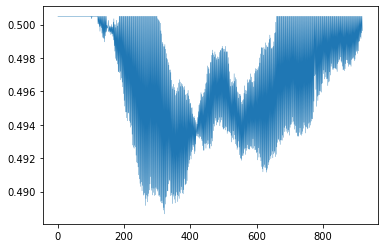

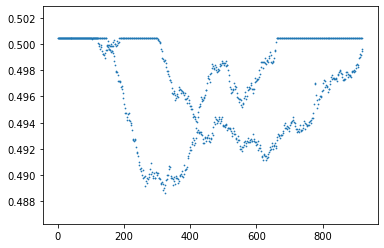

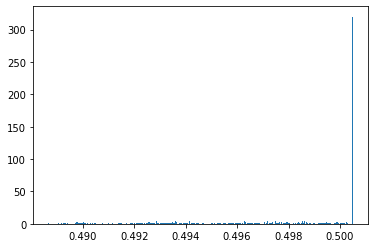

Average value is:  0.49693942
Total Predicted Positive:  520  out of  920
56.52173913043478 %
Epoch:  3
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 793ms/step - loss: 0.6921 - acc: 1.0000 - val_loss: 0.6988 - val_acc: 0.3837
(920, 1)


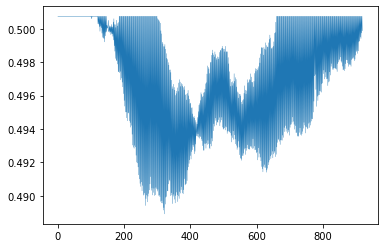

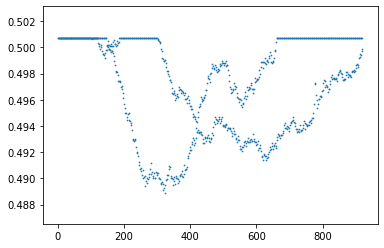

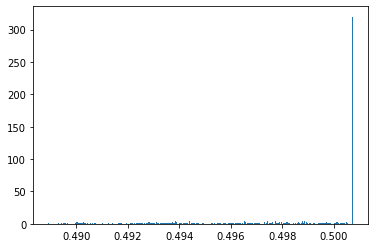

Average value is:  0.49718937
Total Predicted Positive:  520  out of  920
56.52173913043478 %
Epoch:  4
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 786ms/step - loss: 0.6916 - acc: 1.0000 - val_loss: 0.6983 - val_acc: 0.3946
(920, 1)


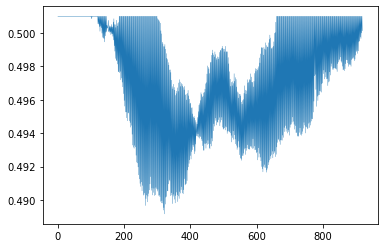

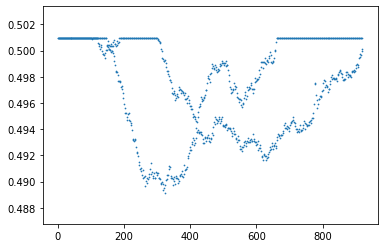

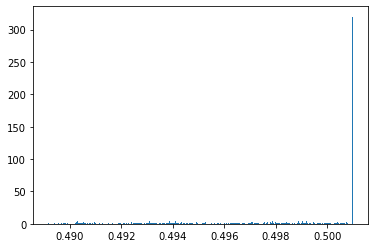

Average value is:  0.49743935
Total Predicted Positive:  520  out of  920
56.52173913043478 %
Epoch:  5
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 807ms/step - loss: 0.6911 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.4065
(920, 1)


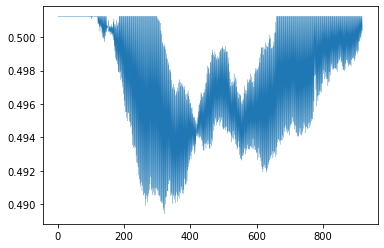

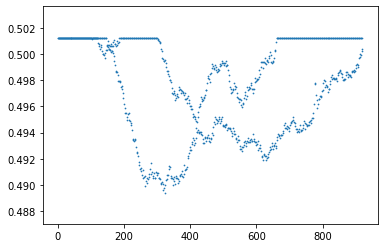

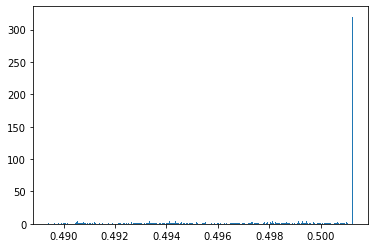

Average value is:  0.49768928
Total Predicted Positive:  520  out of  920
56.52173913043478 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 1
## create the model
modelDense1 = 0
modelDense1 = Sequential()
modelDense1.add(Flatten())
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(1, activation='sigmoid'))
modelDense1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense1.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelDense1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


In [0]:
np.unique(y_pred)

array([0., 1.], dtype=float32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 7ms/step - loss: 0.6709 - acc: 0.9838 - val_loss: 0.6486 - val_acc: 1.0000
(736, 1)


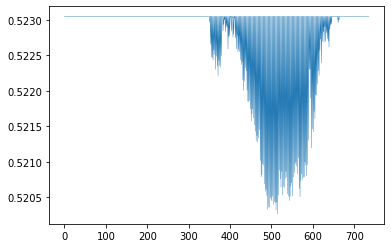

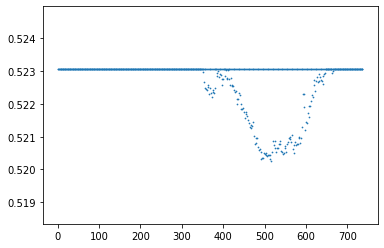

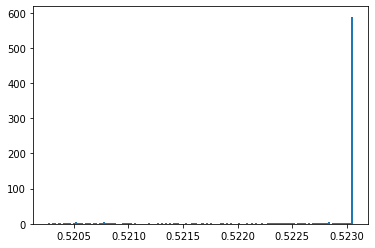

Average value is:  0.5227761
Total Predicted Positive:  608  out of  736
82.6086956521739 %
Epoch:  2
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 5ms/step - loss: 0.6271 - acc: 1.0000 - val_loss: 0.6064 - val_acc: 1.0000
(736, 1)


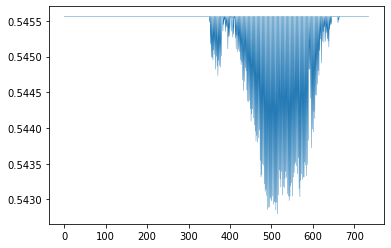

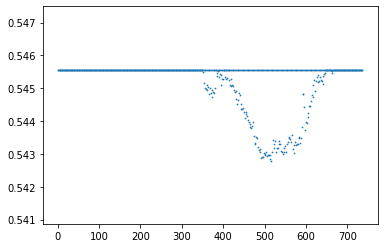

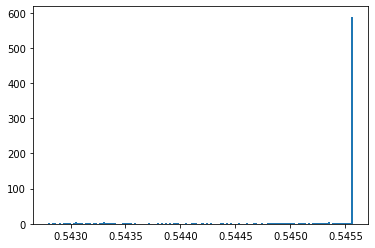

Average value is:  0.5452913
Total Predicted Positive:  608  out of  736
82.6086956521739 %
Epoch:  3
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 6ms/step - loss: 0.5864 - acc: 1.0000 - val_loss: 0.5673 - val_acc: 1.0000
(736, 1)


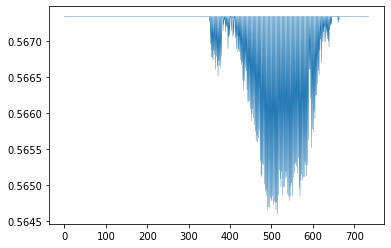

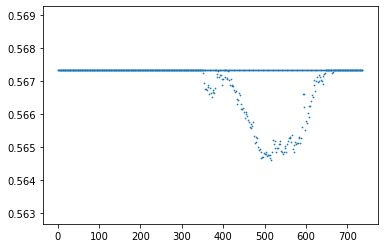

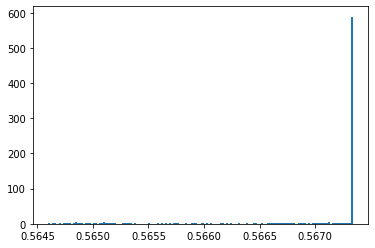

Average value is:  0.567067
Total Predicted Positive:  608  out of  736
82.6086956521739 %
Epoch:  4
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 5ms/step - loss: 0.5487 - acc: 1.0000 - val_loss: 0.5309 - val_acc: 1.0000
(736, 1)


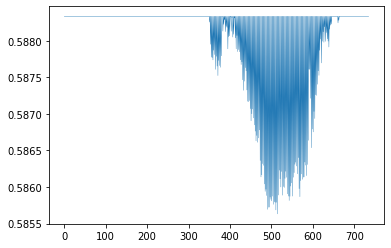

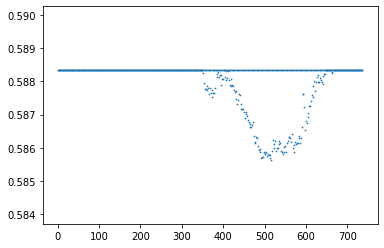

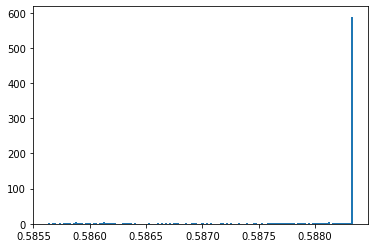

Average value is:  0.5880685
Total Predicted Positive:  608  out of  736
82.6086956521739 %
Epoch:  5
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 6ms/step - loss: 0.5136 - acc: 1.0000 - val_loss: 0.4972 - val_acc: 1.0000
(736, 1)


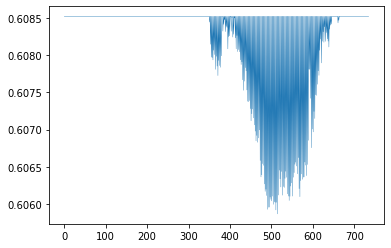

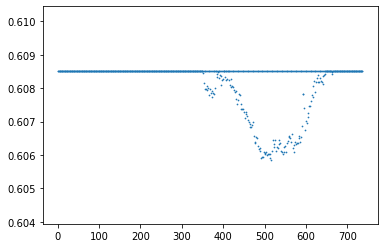

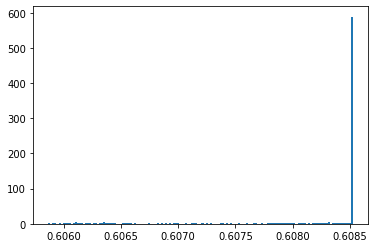

Average value is:  0.6082619
Total Predicted Positive:  608  out of  736
82.6086956521739 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 2
## create the model
modelDense2 = 0
modelDense2 = Sequential()
modelDense2.add(Flatten())
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(1, activation='sigmoid'))
modelDense2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense2.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelDense2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 2s 4ms/step - loss: 0.6492 - acc: 0.9919 - val_loss: 0.6070 - val_acc: 1.0000
(552, 1)


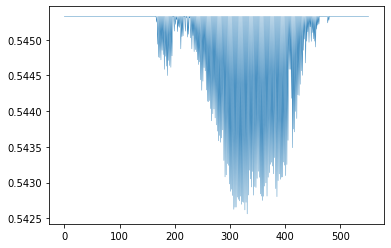

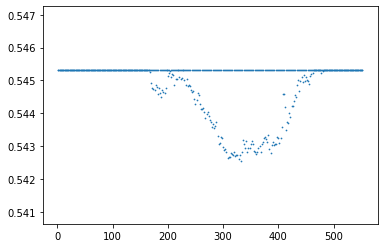

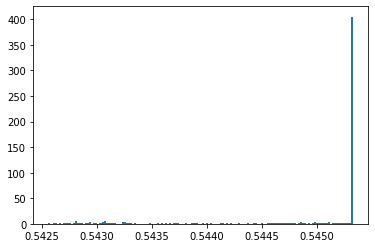

Average value is:  0.5449625
Total Predicted Positive:  434  out of  552
78.62318840579711 %
Epoch:  2
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 0.5682 - acc: 1.0000 - val_loss: 0.5318 - val_acc: 1.0000
(552, 1)


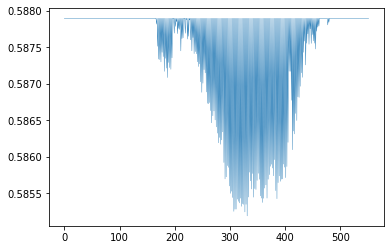

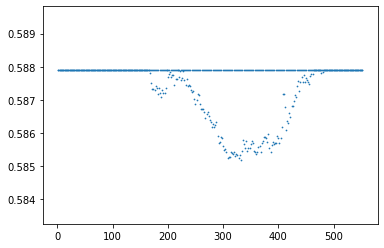

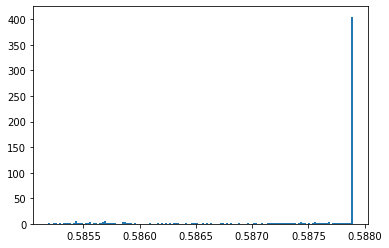

Average value is:  0.587537
Total Predicted Positive:  434  out of  552
78.62318840579711 %
Epoch:  3
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 0.4983 - acc: 1.0000 - val_loss: 0.4669 - val_acc: 1.0000
(552, 1)


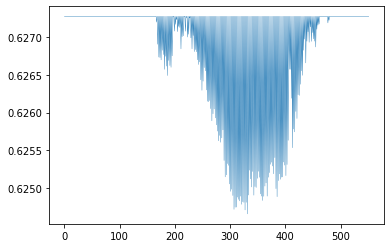

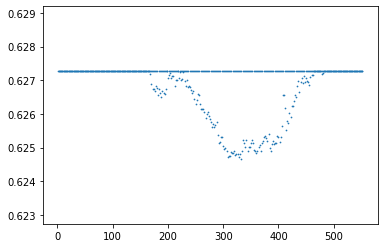

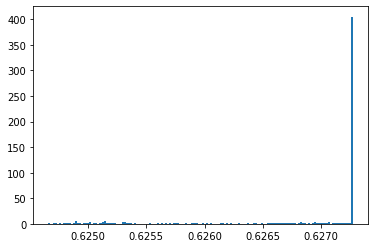

Average value is:  0.6269274
Total Predicted Positive:  434  out of  552
78.62318840579711 %
Epoch:  4
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 0.4380 - acc: 1.0000 - val_loss: 0.4110 - val_acc: 1.0000
(552, 1)


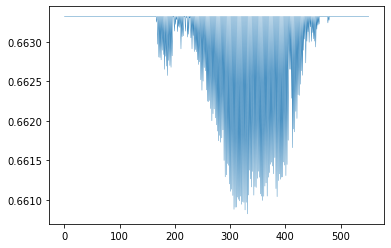

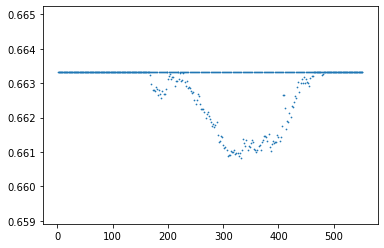

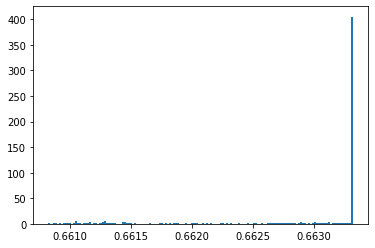

Average value is:  0.6629914
Total Predicted Positive:  434  out of  552
78.62318840579711 %
Epoch:  5
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 0.3860 - acc: 1.0000 - val_loss: 0.3628 - val_acc: 1.0000
(552, 1)


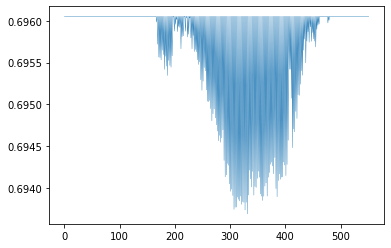

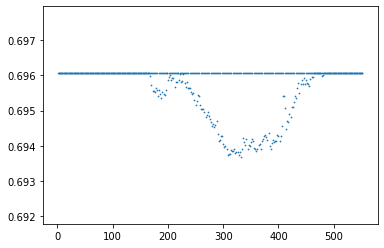

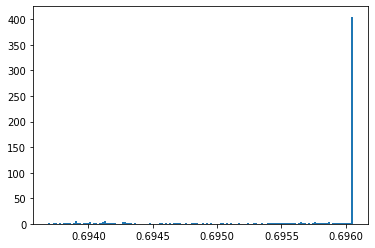

Average value is:  0.6957418
Total Predicted Positive:  434  out of  552
78.62318840579711 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 3
## create the model
modelDense3 = 0
modelDense3 = Sequential()
modelDense3.add(Flatten())
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(1, activation='sigmoid'))
modelDense3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense3.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelDense3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 2s 3ms/step - loss: 0.6286 - acc: 0.9964 - val_loss: 0.5678 - val_acc: 1.0000
(368, 1)


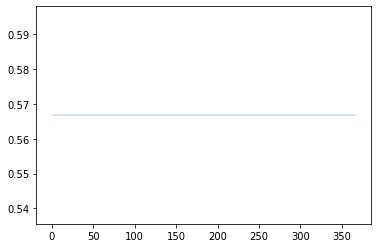

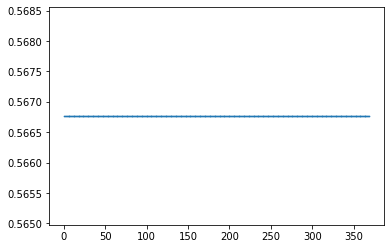

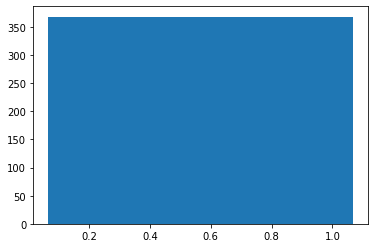

Average value is:  0.56676626
Total Predicted Positive:  368  out of  368
100.0 %
Epoch:  2
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 2ms/step - loss: 0.5158 - acc: 1.0000 - val_loss: 0.4669 - val_acc: 1.0000
(368, 1)


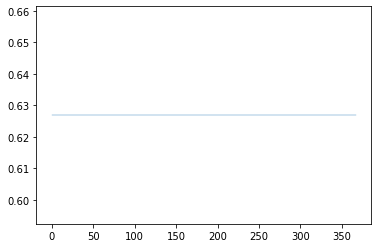

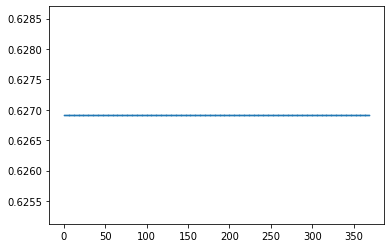

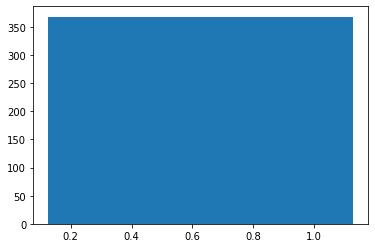

Average value is:  0.6269127
Total Predicted Positive:  368  out of  368
100.0 %
Epoch:  3
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 2ms/step - loss: 0.4253 - acc: 1.0000 - val_loss: 0.3861 - val_acc: 1.0000
(368, 1)


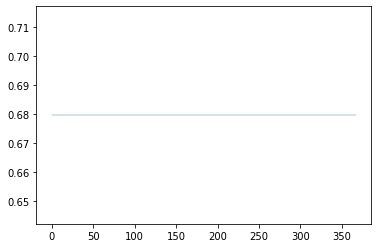

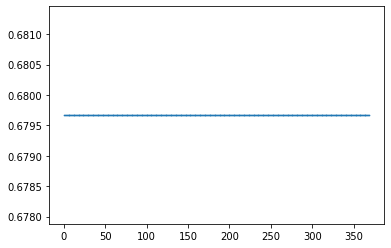

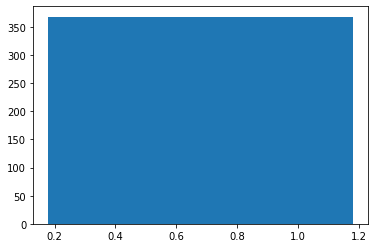

Average value is:  0.6796704
Total Predicted Positive:  368  out of  368
100.0 %
Epoch:  4
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 2ms/step - loss: 0.3528 - acc: 1.0000 - val_loss: 0.3214 - val_acc: 1.0000
(368, 1)


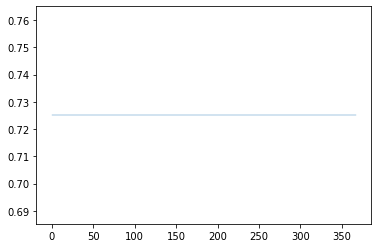

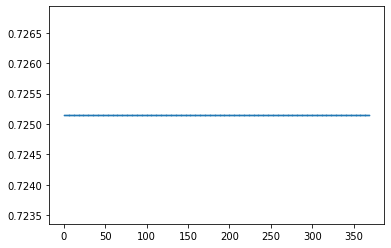

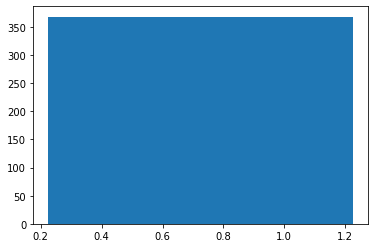

Average value is:  0.7251468
Total Predicted Positive:  368  out of  368
100.0 %
Epoch:  5
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 3ms/step - loss: 0.2945 - acc: 1.0000 - val_loss: 0.2693 - val_acc: 1.0000
(368, 1)


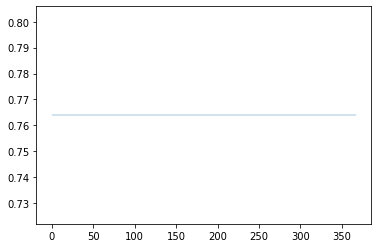

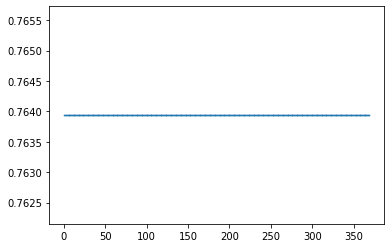

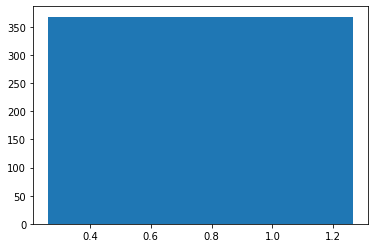

Average value is:  0.7639391
Total Predicted Positive:  368  out of  368
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 4
## create the model
modelDense4 = 0
modelDense4 = Sequential()
modelDense4.add(Flatten())
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(1, activation='sigmoid'))
modelDense4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense4.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelDense4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 737 samples, validate on 184 samples
Epoch 1/1





737/737 [==============================] - 11s 15ms/step - loss: 0.6

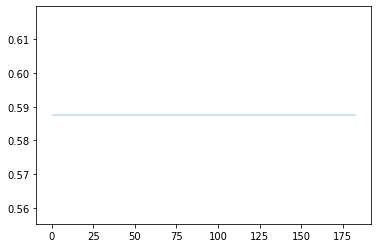

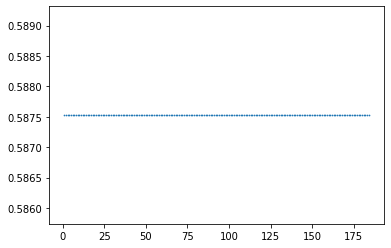

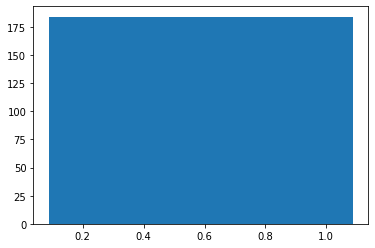

Average value is:  0.58752865
Total Predicted Positive:  184  out of  184
100.0 %
Epoch:  2
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 2ms/step - loss: 0.4688 - acc: 1.0000 - val_loss: 0.4113 - val_acc: 1.0000
(184, 1)


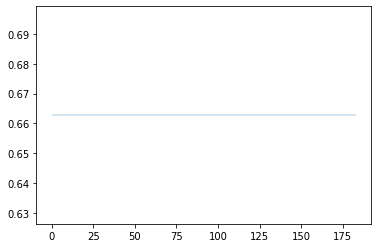

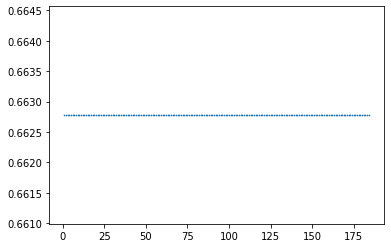

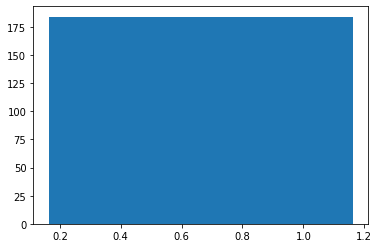

Average value is:  0.6627788
Total Predicted Positive:  184  out of  184
100.0 %
Epoch:  3
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 2ms/step - loss: 0.3644 - acc: 1.0000 - val_loss: 0.3216 - val_acc: 1.0000
(184, 1)


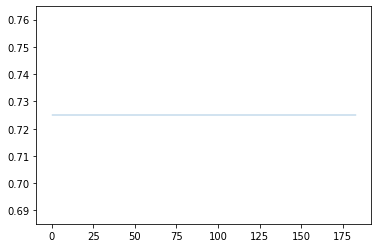

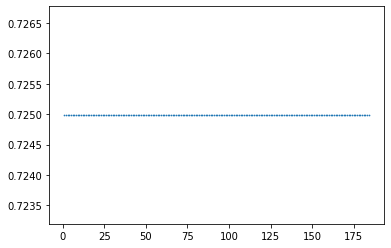

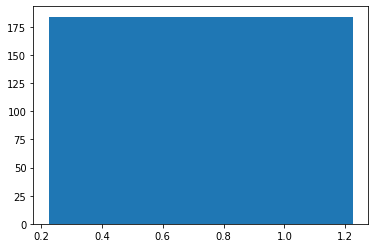

Average value is:  0.72498614
Total Predicted Positive:  184  out of  184
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 5
## create the model
modelDense5 = 0
modelDense5 = Sequential()
modelDense5.add(Flatten())
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(1, activation='sigmoid'))
modelDense5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense5.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelDense5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 0.5913 - acc: 0.9967 - val_loss: 0.5001 - val_acc: 1.0000
(10, 1)


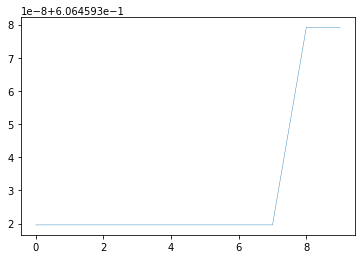

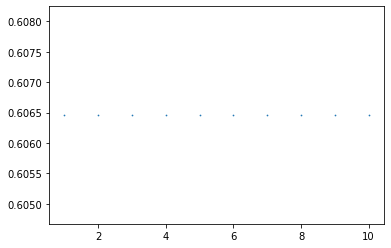

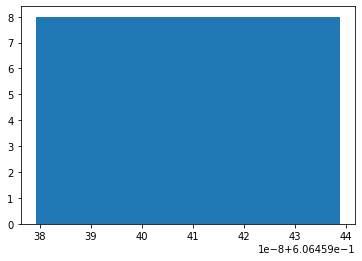

Average value is:  0.6064593
Total Predicted Positive:  10  out of  10
100.0 %
Epoch:  2
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 0.4290 - acc: 1.0000 - val_loss: 0.3657 - val_acc: 1.0000
(10, 1)


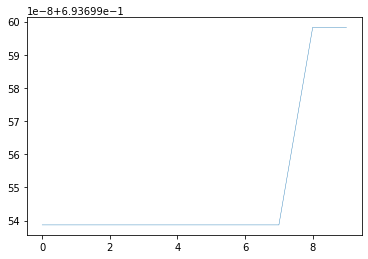

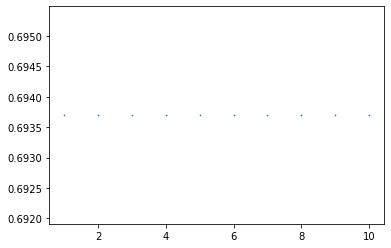

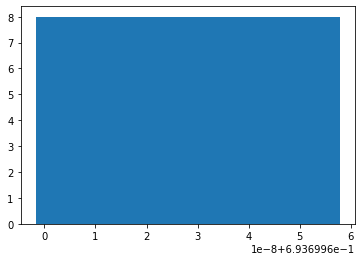

Average value is:  0.69369954
Total Predicted Positive:  10  out of  10
100.0 %
Epoch:  3
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 0.3163 - acc: 1.0000 - val_loss: 0.2722 - val_acc: 1.0000
(10, 1)


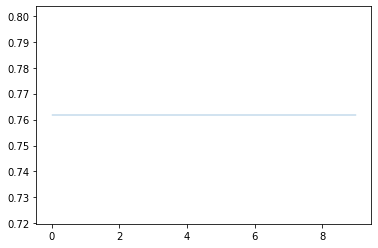

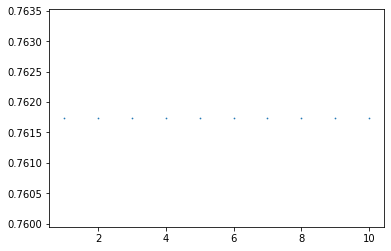

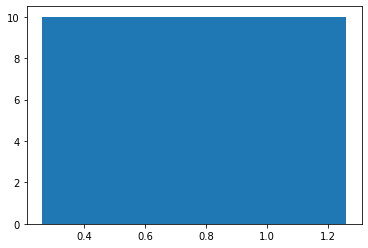

Average value is:  0.76173437
Total Predicted Positive:  10  out of  10
100.0 %
Epoch:  4
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 0.2374 - acc: 1.0000 - val_loss: 0.2061 - val_acc: 1.0000
(10, 1)


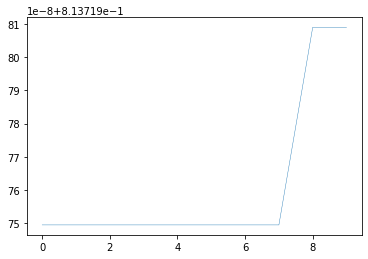

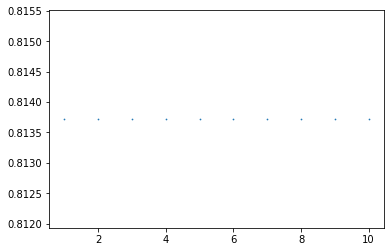

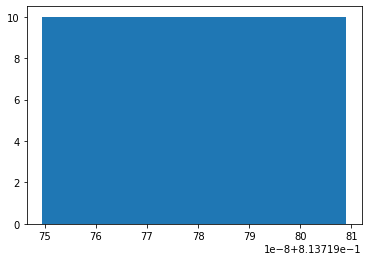

Average value is:  0.81371975
Total Predicted Positive:  10  out of  10
100.0 %
Epoch:  5
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 0.1812 - acc: 1.0000 - val_loss: 0.1586 - val_acc: 1.0000
(10, 1)


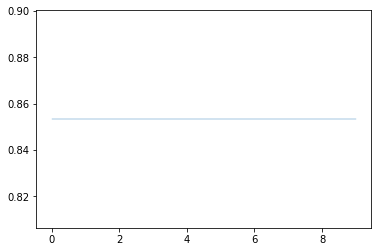

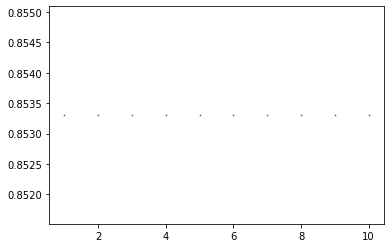

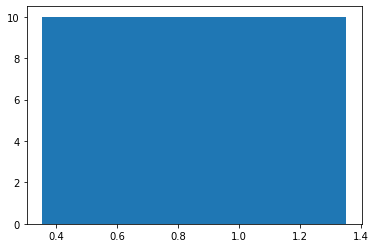

Average value is:  0.8533033
Total Predicted Positive:  10  out of  10
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 6
## create the model
modelDense6 = 0
modelDense6 = Sequential()
modelDense6.add(Flatten())
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(1, activation='sigmoid'))
modelDense6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense6.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelDense6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 649ms/step - loss: 0.6940 - acc: 0.0000e+00 - val_loss: 0.6937 - val_acc: 0.7421
(919, 1)


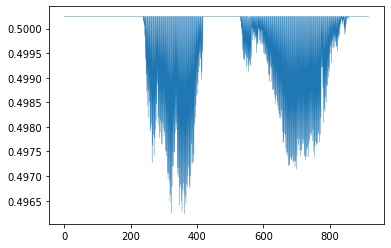

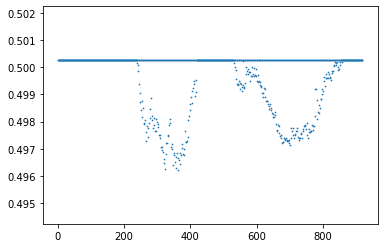

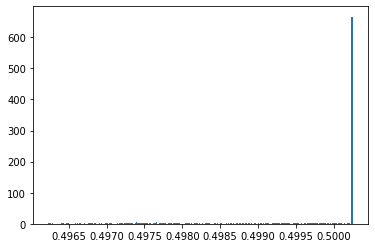

Average value is:  0.499734
Total Predicted Positive:  702  out of  919
76.38737758433079 %
Epoch:  2
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 395ms/step - loss: 0.6926 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.8596
(919, 1)


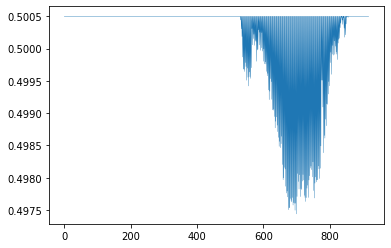

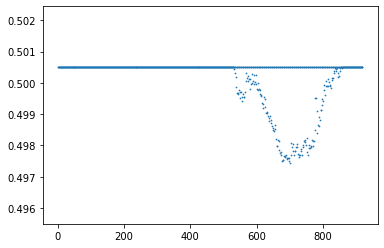

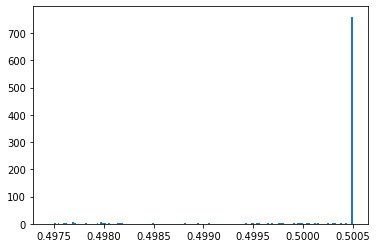

Average value is:  0.5002368
Total Predicted Positive:  773  out of  919
84.11316648531012 %
Epoch:  3
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 414ms/step - loss: 0.6921 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.8825
(919, 1)


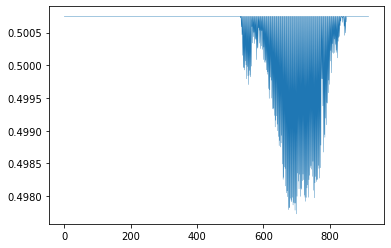

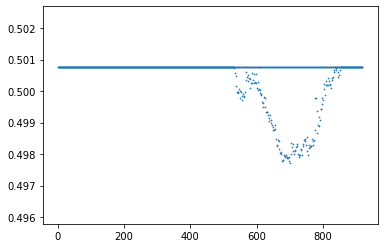

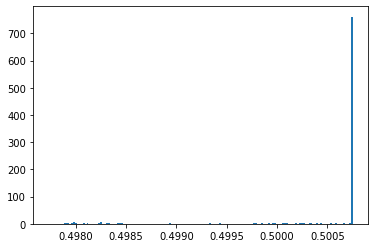

Average value is:  0.50049293
Total Predicted Positive:  775  out of  919
84.33079434167573 %
Epoch:  4
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 408ms/step - loss: 0.6916 - acc: 1.0000 - val_loss: 0.6917 - val_acc: 0.9032
(919, 1)


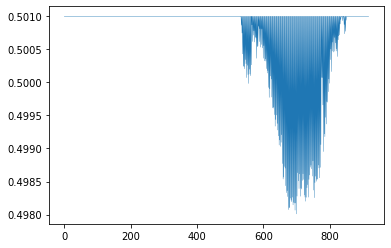

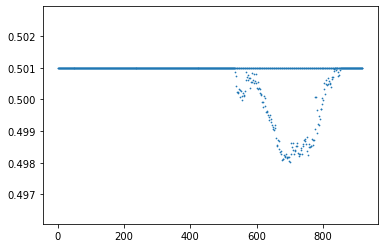

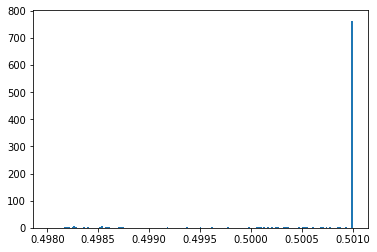

Average value is:  0.50074786
Total Predicted Positive:  775  out of  919
84.33079434167573 %
Epoch:  5
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 411ms/step - loss: 0.6911 - acc: 1.0000 - val_loss: 0.6911 - val_acc: 0.9108
(919, 1)


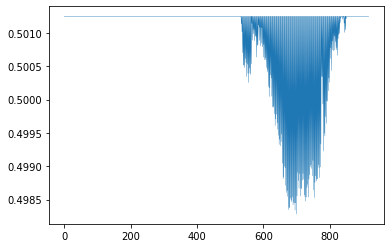

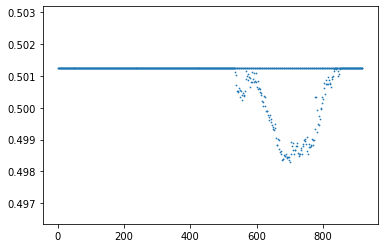

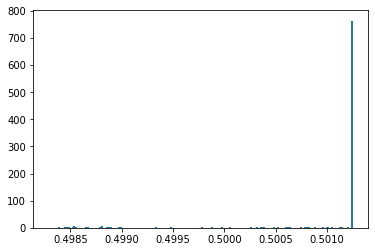

Average value is:  0.5010019
Total Predicted Positive:  777  out of  919
84.54842219804135 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 7
## create the model
modelDense7 = 0
modelDense7 = Sequential()
modelDense7.add(Flatten())
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(1, activation='sigmoid'))
modelDense7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense7.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelDense7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------CNN Model-----------------------------------------------#
###########################################################################################################################


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 19404)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 7s 7s/step - loss: 0.6687 - acc: 1.0000 - val_loss: 0.6181 - val_acc: 0.9065
(920, 1)


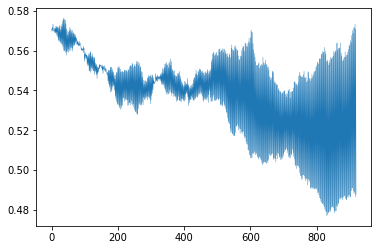

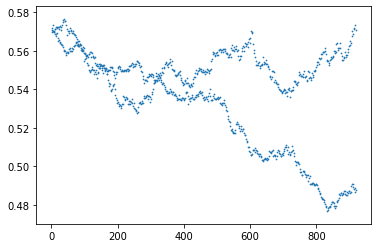

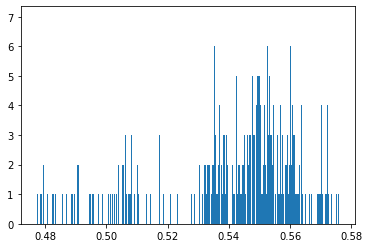

Average value is:  0.53948295
Total Predicted Positive:  564  out of  920
61.30434782608696 %
Epoch:  2
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 839ms/step - loss: 0.5636 - acc: 1.0000 - val_loss: 0.5302 - val_acc: 0.9978
(920, 1)


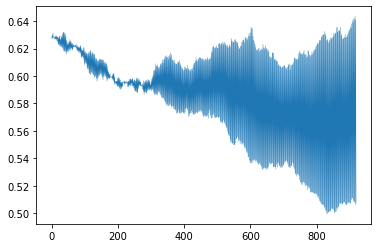

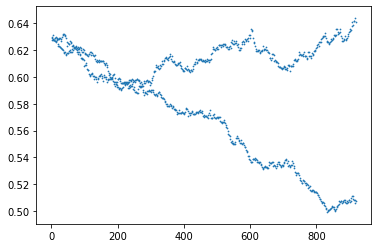

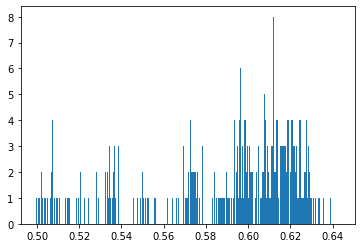

Average value is:  0.5897348
Total Predicted Positive:  599  out of  920
65.1086956521739 %
Epoch:  3
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 831ms/step - loss: 0.4670 - acc: 1.0000 - val_loss: 0.4462 - val_acc: 1.0000
(920, 1)


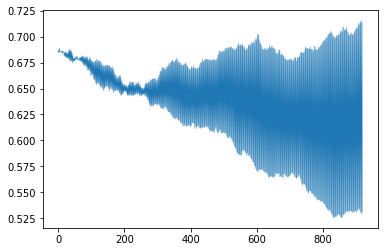

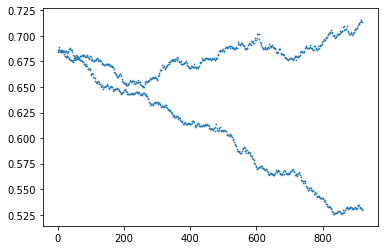

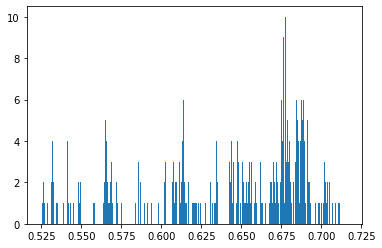

Average value is:  0.6422343
Total Predicted Positive:  593  out of  920
64.45652173913044 %
Epoch:  4
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 801ms/step - loss: 0.3791 - acc: 1.0000 - val_loss: 0.3641 - val_acc: 1.0000
(920, 1)


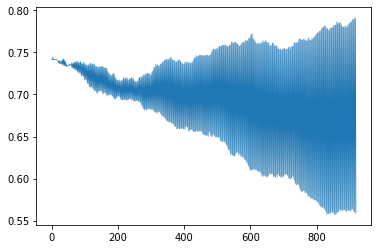

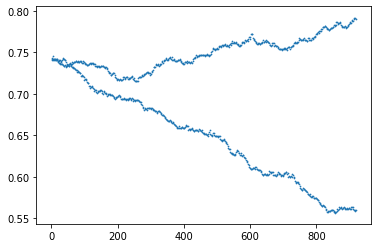

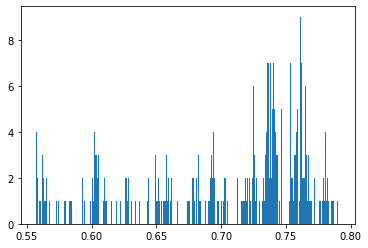

Average value is:  0.6980873
Total Predicted Positive:  552  out of  920
60.0 %
Epoch:  5
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 1s 820ms/step - loss: 0.3000 - acc: 1.0000 - val_loss: 0.2899 - val_acc: 1.0000
(920, 1)


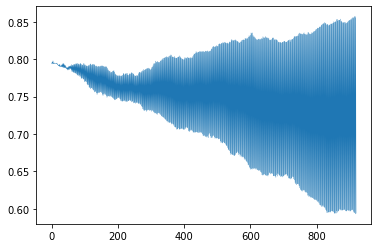

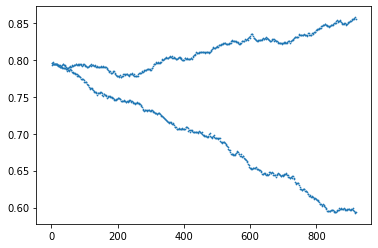

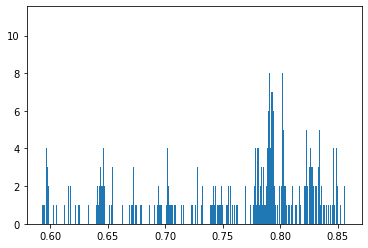

Average value is:  0.75230813
Total Predicted Positive:  541  out of  920
58.80434782608695 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 1
## create the model
modelCNN1 = 0
modelCNN1 = Sequential()
modelCNN1.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN1.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN1.add(Flatten())
modelCNN1.add(Dense(1, activation='sigmoid'))
modelCNN1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN1.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelCNN1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 19404)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 2s 9ms/step - loss: 0.0370 - acc: 1.0000 - val_loss: 6.7123e-05 - val_acc: 1.0000
(736, 1)


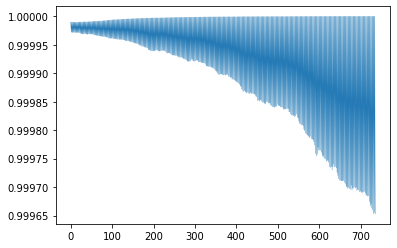

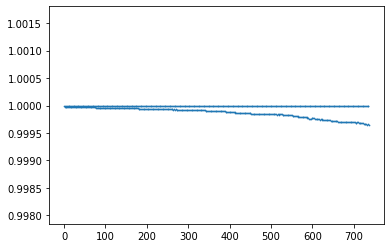

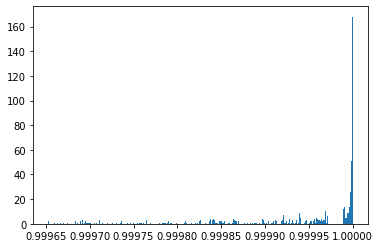

Average value is:  0.9999329
Total Predicted Positive:  490  out of  736
66.57608695652173 %
Epoch:  2
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 6ms/step - loss: 1.3700e-05 - acc: 1.0000 - val_loss: 5.7023e-05 - val_acc: 1.0000
(736, 1)


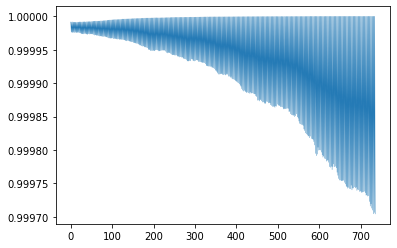

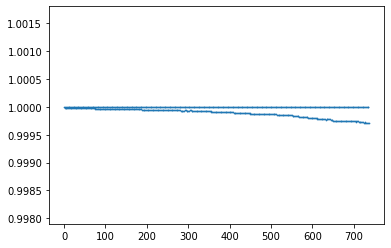

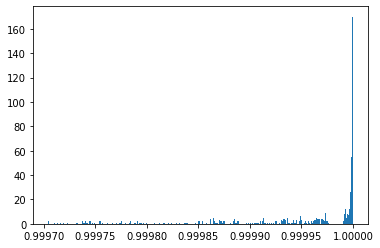

Average value is:  0.99994296
Total Predicted Positive:  490  out of  736
66.57608695652173 %
Epoch:  3
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 5ms/step - loss: 1.1526e-05 - acc: 1.0000 - val_loss: 4.7531e-05 - val_acc: 1.0000
(736, 1)


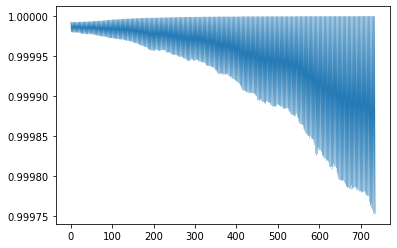

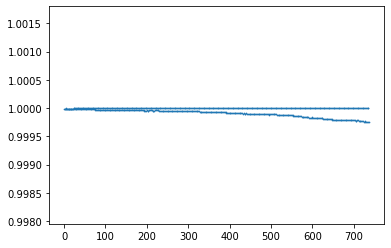

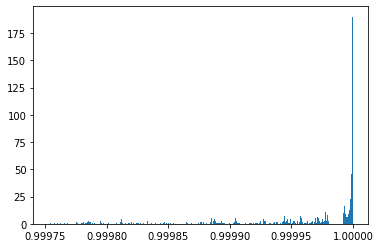

Average value is:  0.99995255
Total Predicted Positive:  490  out of  736
66.57608695652173 %
Epoch:  4
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 6ms/step - loss: 9.5664e-06 - acc: 1.0000 - val_loss: 3.9348e-05 - val_acc: 1.0000
(736, 1)


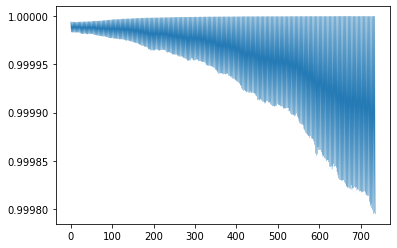

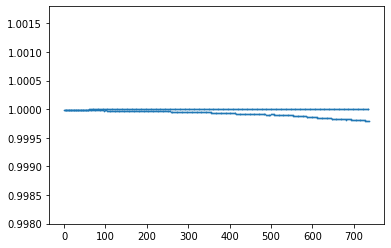

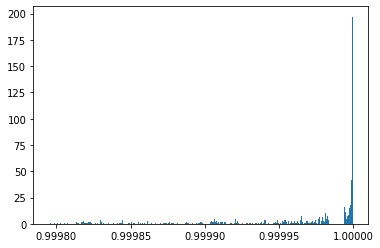

Average value is:  0.9999607
Total Predicted Positive:  490  out of  736
66.57608695652173 %
Epoch:  5
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 1s 6ms/step - loss: 7.9226e-06 - acc: 1.0000 - val_loss: 3.2653e-05 - val_acc: 1.0000
(736, 1)


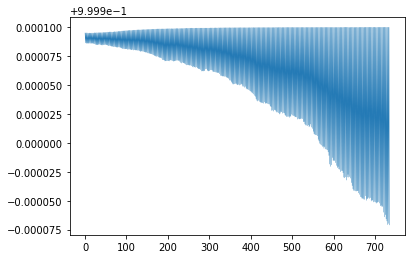

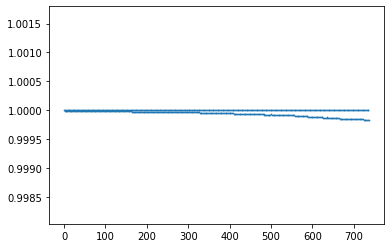

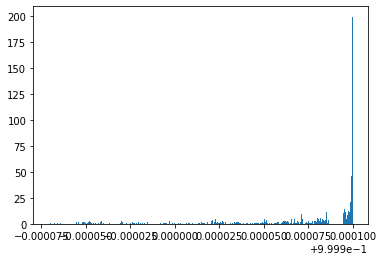

Average value is:  0.99996734
Total Predicted Positive:  493  out of  736
66.9836956521739 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 2
## create the model
modelCNN2 = 0
modelCNN2 = Sequential()
modelCNN2.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN2.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN2.add(Flatten())
modelCNN2.add(Dense(1, activation='sigmoid'))
modelCNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN2.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelCNN2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 2s 6ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 6.3887e-05 - val_acc: 1.0000
(552, 1)


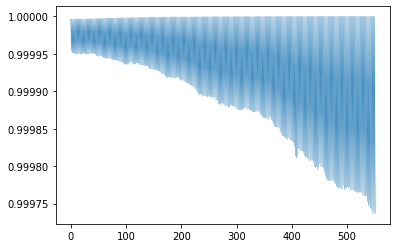

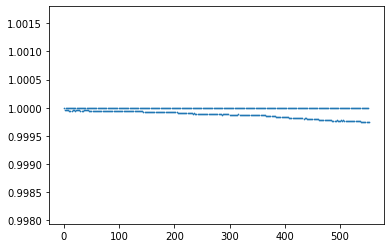

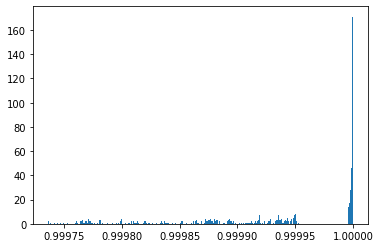

Average value is:  0.9999361
Total Predicted Positive:  332  out of  552
60.14492753623188 %
Epoch:  2
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 1.3076e-05 - acc: 1.0000 - val_loss: 4.4498e-05 - val_acc: 1.0000
(552, 1)


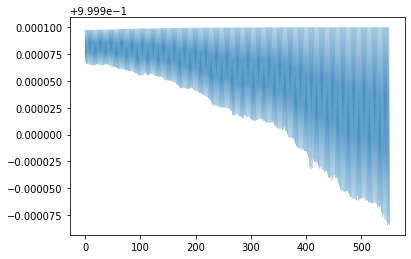

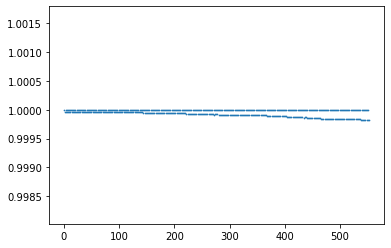

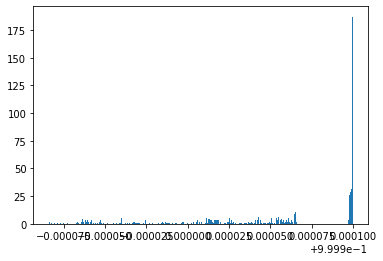

Average value is:  0.99995553
Total Predicted Positive:  332  out of  552
60.14492753623188 %
Epoch:  3
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 4ms/step - loss: 9.0086e-06 - acc: 1.0000 - val_loss: 3.0959e-05 - val_acc: 1.0000
(552, 1)


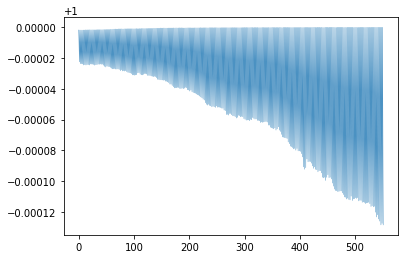

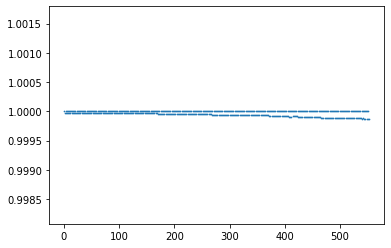

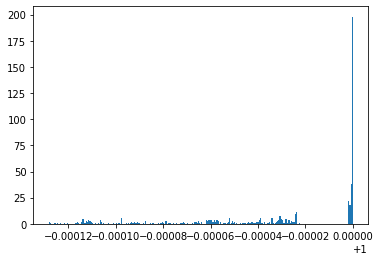

Average value is:  0.9999691
Total Predicted Positive:  332  out of  552
60.14492753623188 %
Epoch:  4
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 6.3162e-06 - acc: 1.0000 - val_loss: 2.2152e-05 - val_acc: 1.0000
(552, 1)


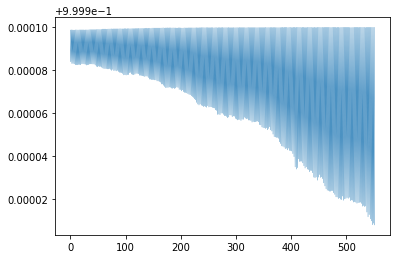

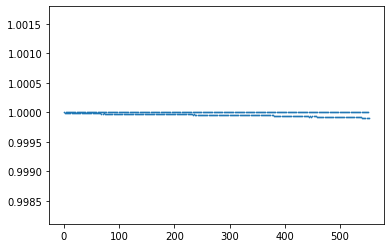

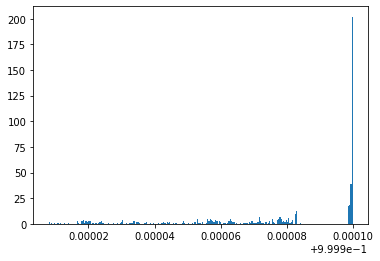

Average value is:  0.9999779
Total Predicted Positive:  334  out of  552
60.507246376811594 %
Epoch:  5
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 1s 3ms/step - loss: 4.5817e-06 - acc: 1.0000 - val_loss: 1.6423e-05 - val_acc: 1.0000
(552, 1)


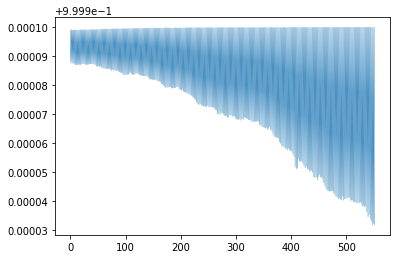

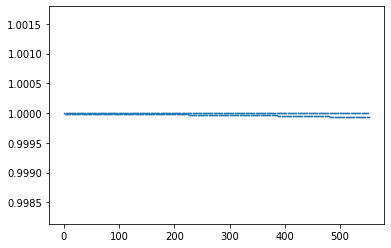

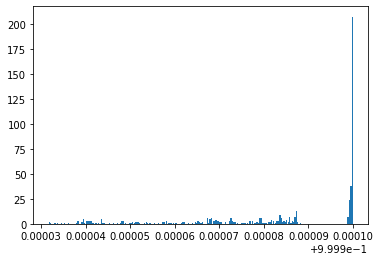

Average value is:  0.9999836
Total Predicted Positive:  334  out of  552
60.507246376811594 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 3
## create the model
modelCNN3 = 0
modelCNN3 = Sequential()
modelCNN3.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN3.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN3.add(Flatten())
modelCNN3.add(Dense(1, activation='sigmoid'))
modelCNN3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN3.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelCNN3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 2s 4ms/step - loss: 0.0133 - acc: 0.9982 - val_loss: 5.3634e-05 - val_acc: 1.0000
(368, 1)


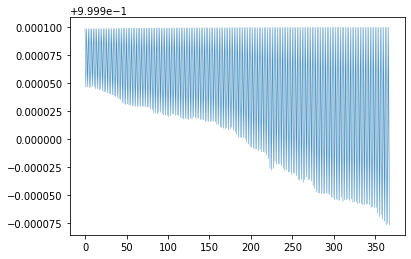

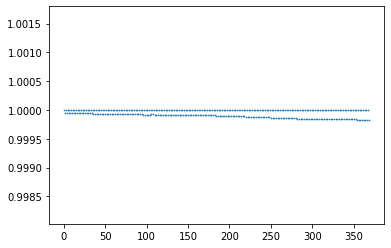

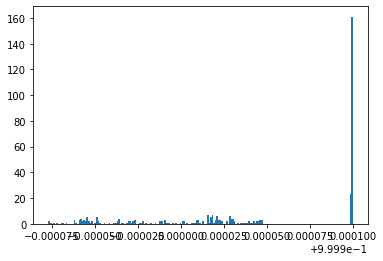

Average value is:  0.99994636
Total Predicted Positive:  188  out of  368
51.08695652173913 %
Epoch:  2
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 3ms/step - loss: 9.3331e-06 - acc: 1.0000 - val_loss: 3.0668e-05 - val_acc: 1.0000
(368, 1)


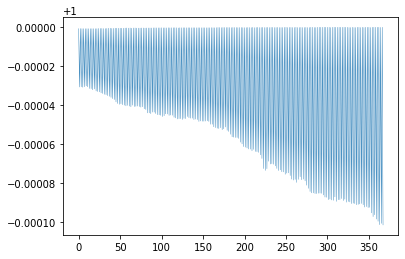

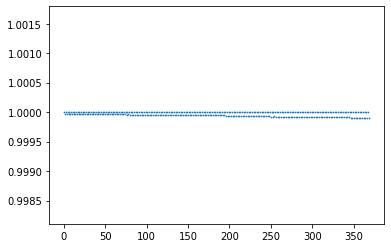

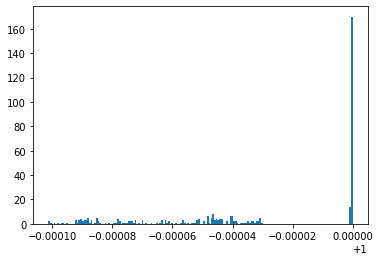

Average value is:  0.9999694
Total Predicted Positive:  188  out of  368
51.08695652173913 %
Epoch:  3
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 2ms/step - loss: 5.4265e-06 - acc: 1.0000 - val_loss: 1.8831e-05 - val_acc: 1.0000
(368, 1)


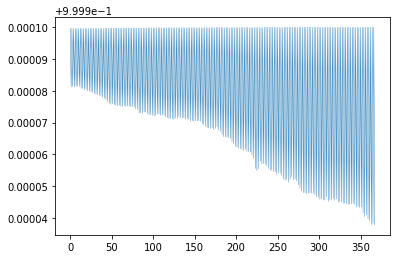

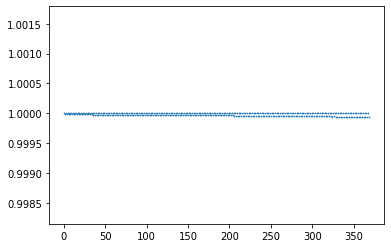

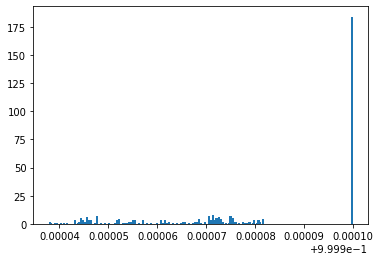

Average value is:  0.9999813
Total Predicted Positive:  188  out of  368
51.08695652173913 %
Epoch:  4
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 2ms/step - loss: 3.4155e-06 - acc: 1.0000 - val_loss: 1.2386e-05 - val_acc: 1.0000
(368, 1)


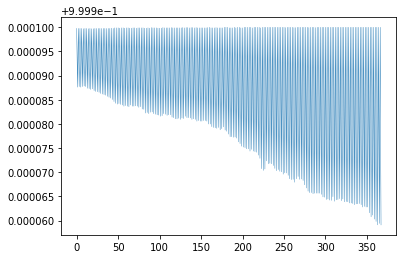

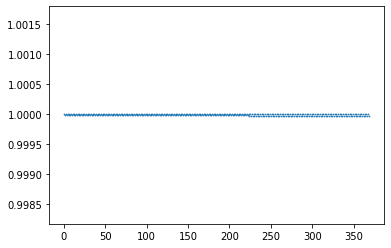

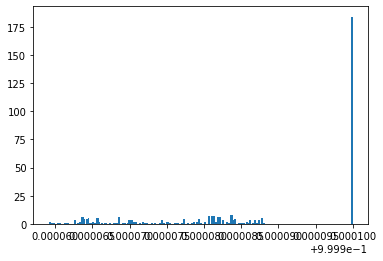

Average value is:  0.99998766
Total Predicted Positive:  188  out of  368
51.08695652173913 %
Epoch:  5
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 1s 3ms/step - loss: 2.3001e-06 - acc: 1.0000 - val_loss: 8.6165e-06 - val_acc: 1.0000
(368, 1)


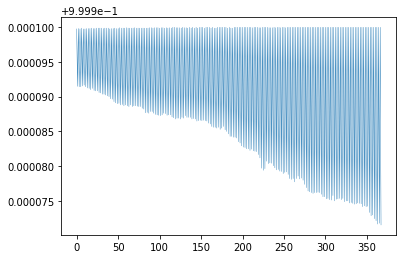

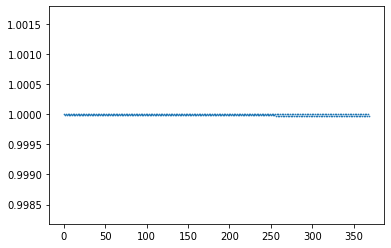

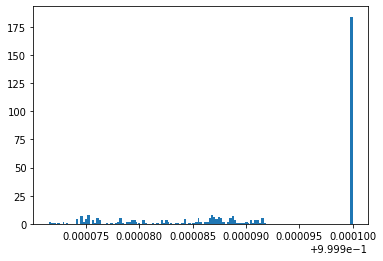

Average value is:  0.9999915
Total Predicted Positive:  187  out of  368
50.815217391304344 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 4
## create the model
modelCNN4 = 0
modelCNN4 = Sequential()
modelCNN4.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN4.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN4.add(Flatten())
modelCNN4.add(Dense(1, activation='sigmoid'))
modelCNN4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN4.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelCNN4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 3ms/step - loss: 0.0116 - acc: 0.9973 - val_loss: 5.6832e-05 - val_acc: 1.0000
(184, 1)


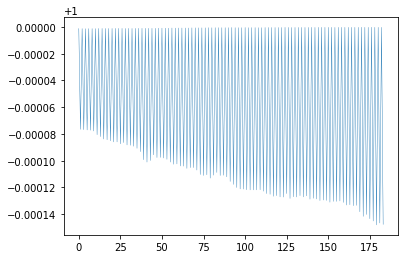

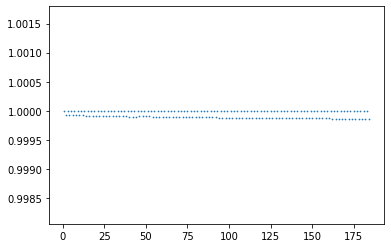

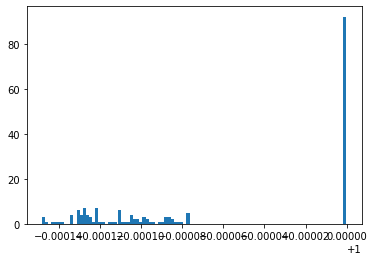

Average value is:  0.9999432
Total Predicted Positive:  92  out of  184
50.0 %
Epoch:  2
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 2ms/step - loss: 9.4782e-06 - acc: 1.0000 - val_loss: 2.3612e-05 - val_acc: 1.0000
(184, 1)


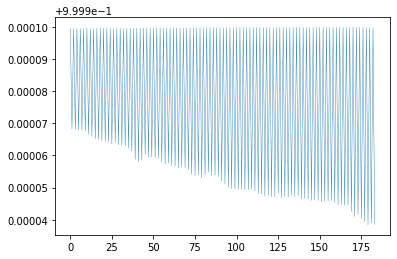

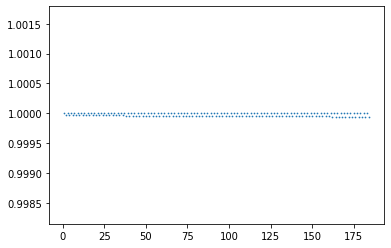

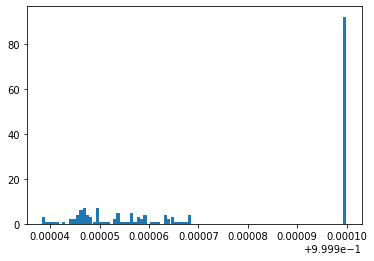

Average value is:  0.99997646
Total Predicted Positive:  92  out of  184
50.0 %
Epoch:  3
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 2ms/step - loss: 4.3855e-06 - acc: 1.0000 - val_loss: 1.2428e-05 - val_acc: 1.0000
(184, 1)


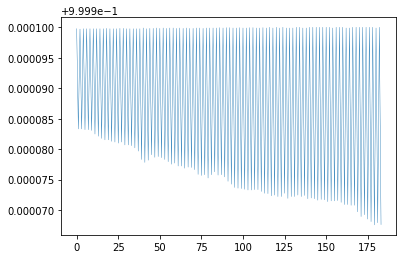

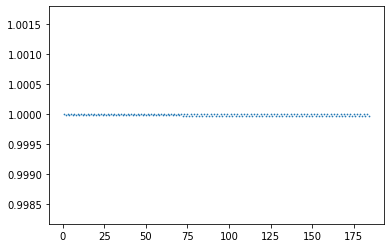

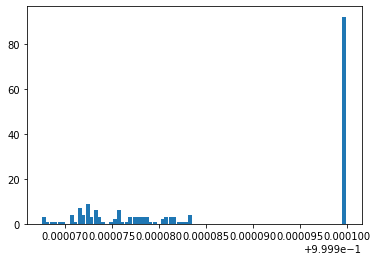

Average value is:  0.99998754
Total Predicted Positive:  92  out of  184
50.0 %
Epoch:  4
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 2ms/step - loss: 2.4639e-06 - acc: 1.0000 - val_loss: 7.5206e-06 - val_acc: 1.0000
(184, 1)


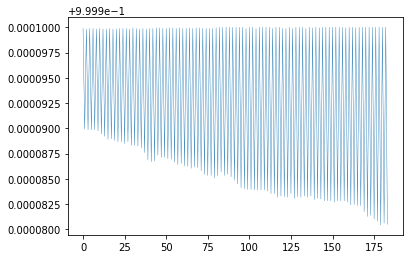

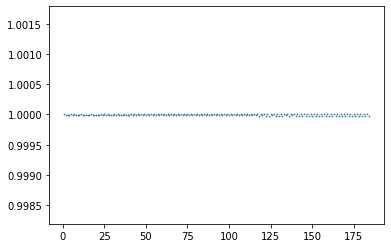

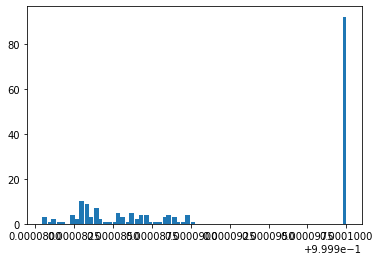

Average value is:  0.99999255
Total Predicted Positive:  92  out of  184
50.0 %
Epoch:  5
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 2s 2ms/step - loss: 1.5348e-06 - acc: 1.0000 - val_loss: 4.9530e-06 - val_acc: 1.0000
(184, 1)


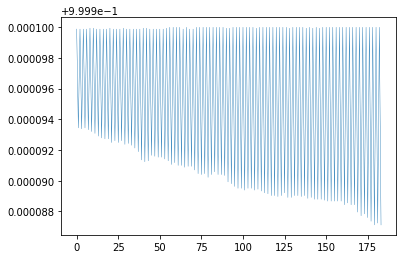

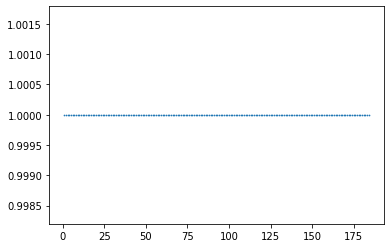

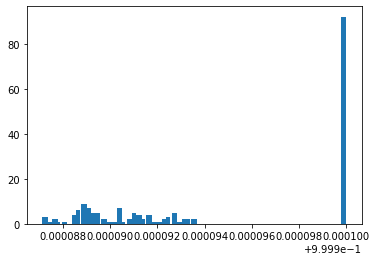

Average value is:  0.9999951
Total Predicted Positive:  92  out of  184
50.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 5
## create the model
modelCNN5 = 0
modelCNN5 = Sequential()
modelCNN5.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN5.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN5.add(Flatten())
modelCNN5.add(Dense(1, activation='sigmoid'))
modelCNN5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN5.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelCNN5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 3s 3ms/step - loss: 0.0108 - acc: 0.9978 - val_loss: 3.7385e-05 - val_acc: 1.0000
(10, 1)


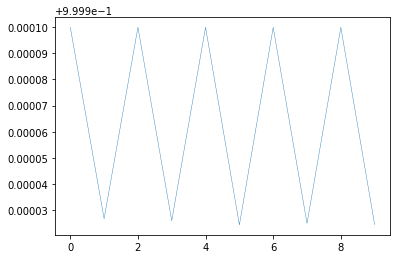

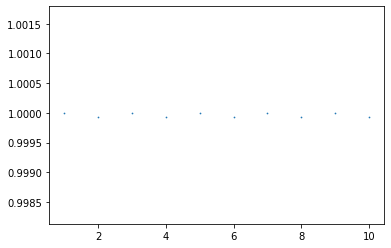

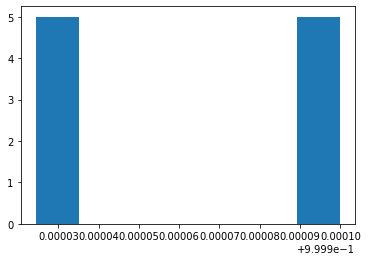

Average value is:  0.9999626
Total Predicted Positive:  5  out of  10
50.0 %
Epoch:  2
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 7.2084e-06 - acc: 1.0000 - val_loss: 1.5867e-05 - val_acc: 1.0000
(10, 1)


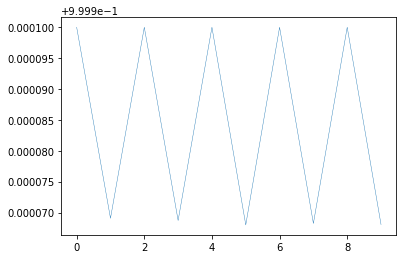

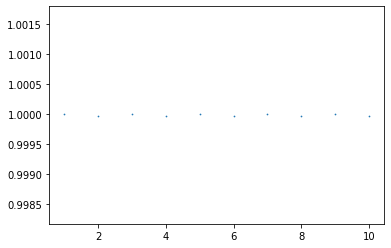

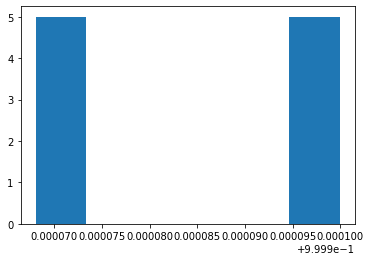

Average value is:  0.99998415
Total Predicted Positive:  5  out of  10
50.0 %
Epoch:  3
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 3.3664e-06 - acc: 1.0000 - val_loss: 8.3447e-06 - val_acc: 1.0000
(10, 1)


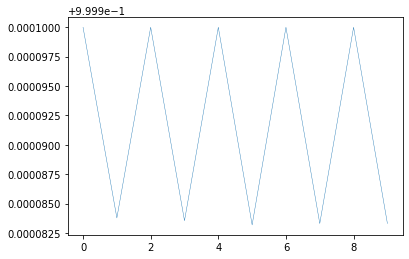

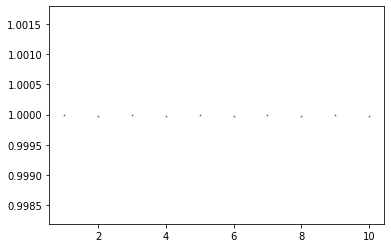

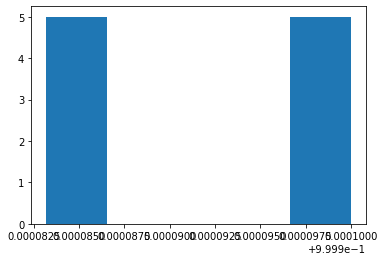

Average value is:  0.9999918
Total Predicted Positive:  5  out of  10
50.0 %
Epoch:  4
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 1.8715e-06 - acc: 1.0000 - val_loss: 4.9830e-06 - val_acc: 1.0000
(10, 1)


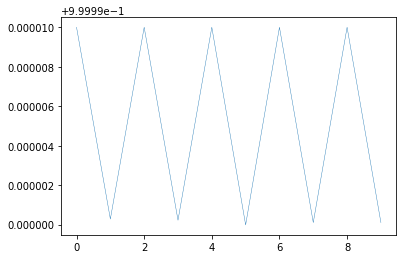

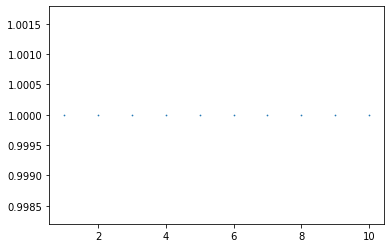

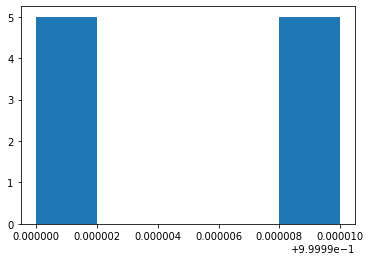

Average value is:  0.99999505
Total Predicted Positive:  5  out of  10
50.0 %
Epoch:  5
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 2s 2ms/step - loss: 1.1596e-06 - acc: 1.0000 - val_loss: 3.2306e-06 - val_acc: 1.0000
(10, 1)


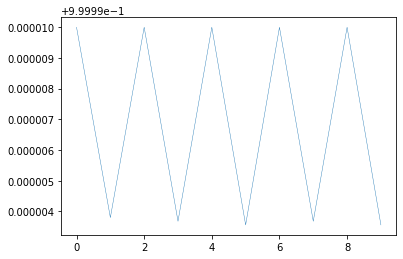

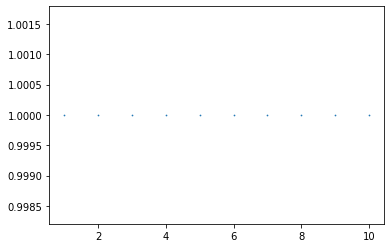

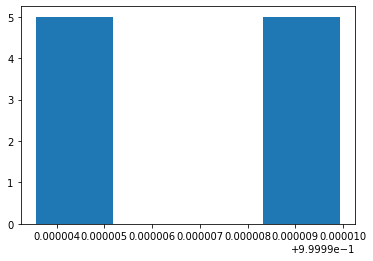

Average value is:  0.99999684
Total Predicted Positive:  5  out of  10
50.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 6
## create the model
modelCNN6 = 0
modelCNN6 = Sequential()
modelCNN6.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN6.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN6.add(Flatten())
modelCNN6.add(Dense(1, activation='sigmoid'))
modelCNN6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN6.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelCNN6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 2s 954ms/step - loss: 0.6852 - acc: 0.5000 - val_loss: 0.5997 - val_acc: 0.9129
(919, 1)


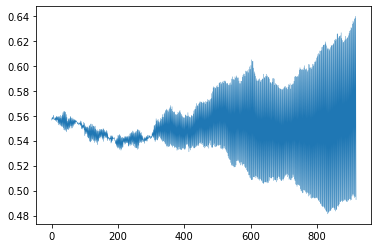

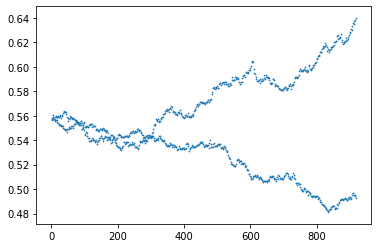

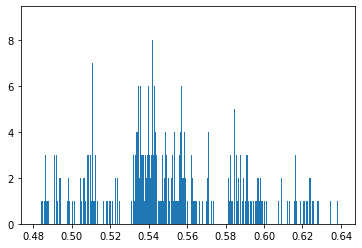

Average value is:  0.55005324
Total Predicted Positive:  407  out of  919
44.28726877040261 %
Epoch:  2
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 445ms/step - loss: 0.5779 - acc: 0.5000 - val_loss: 0.5121 - val_acc: 1.0000
(919, 1)


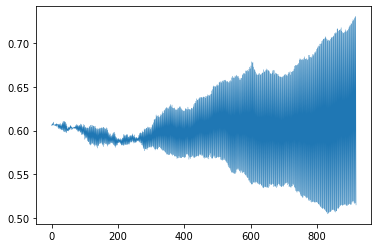

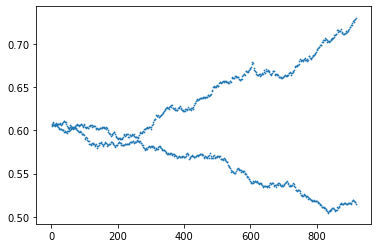

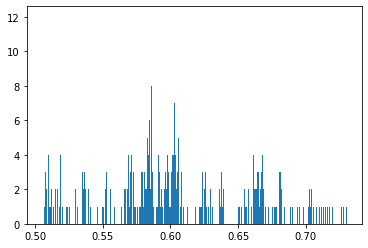

Average value is:  0.6015689
Total Predicted Positive:  422  out of  919
45.91947769314472 %
Epoch:  3
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 447ms/step - loss: 0.4890 - acc: 1.0000 - val_loss: 0.4337 - val_acc: 1.0000
(919, 1)


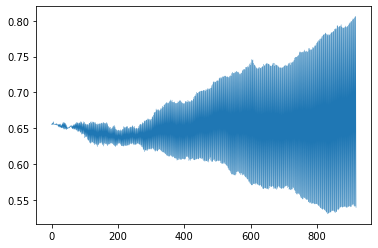

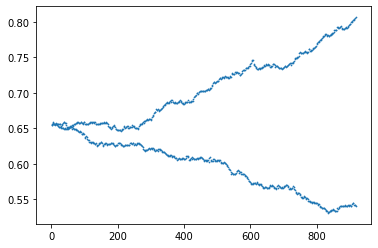

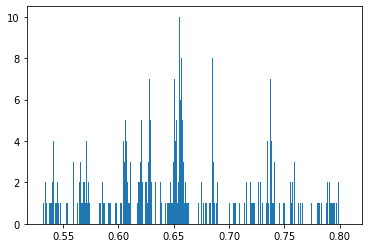

Average value is:  0.65178454
Total Predicted Positive:  441  out of  919
47.98694232861806 %
Epoch:  4
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 435ms/step - loss: 0.4160 - acc: 1.0000 - val_loss: 0.3620 - val_acc: 1.0000
(919, 1)


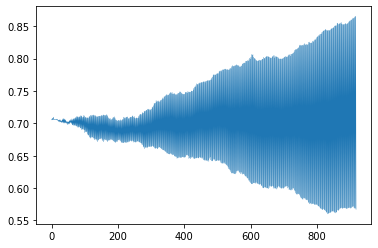

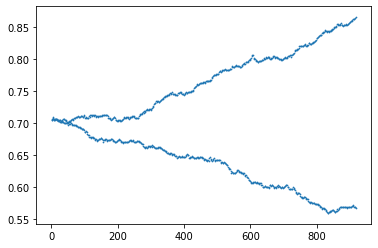

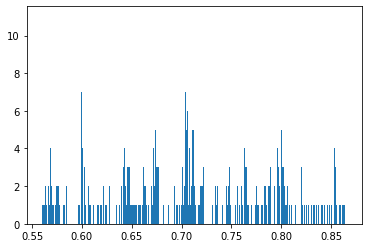

Average value is:  0.70093083
Total Predicted Positive:  480  out of  919
52.23068552774755 %
Epoch:  5
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 1s 441ms/step - loss: 0.3557 - acc: 1.0000 - val_loss: 0.2987 - val_acc: 1.0000
(919, 1)


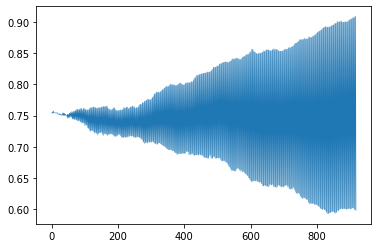

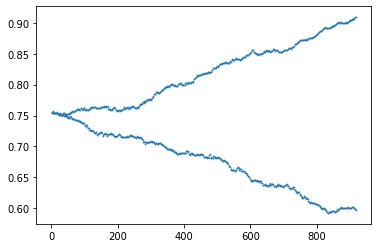

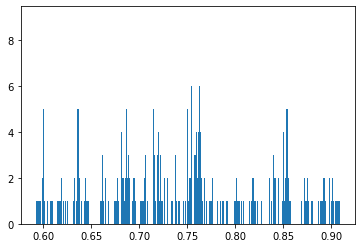

Average value is:  0.74681616
Total Predicted Positive:  486  out of  919
52.8835690968444 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 7
## create the model
modelCNN7 = 0
modelCNN7 = Sequential()
modelCNN7.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN7.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN7.add(Flatten())
modelCNN7.add(Dense(1, activation='sigmoid'))
modelCNN7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN7.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelCNN7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------RNN Model-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters, for RNN particularly
# https://datascience.stackexchange.com/questions/20442/recurrent-neural-network-producing-same-predictions
# Has suggested that increasing batch size will help RNN stop predicting the same value for all
batch_size_user = 150
#epoch_user = 1
#times_to_loop_model = 5

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
150
1
3


In [0]:
print(input_shape)
print(flatten_shape)

(None, 100, 200, 3)
(None, 20000, 3)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 1.0000
(920, 1)


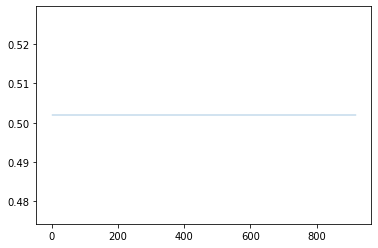

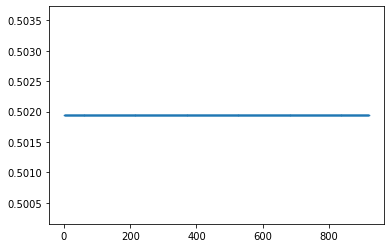

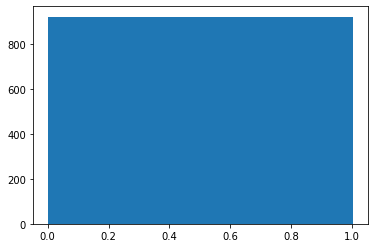

Average value is:  0.50194305
Total Predicted Positive:  0  out of  920
0.0 %
Epoch:  2
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
(920, 1)


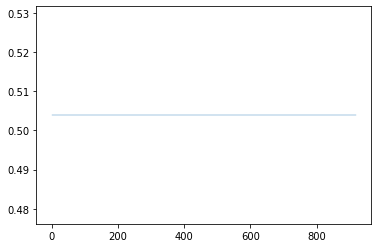

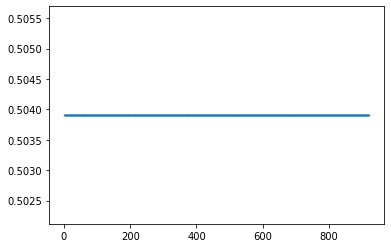

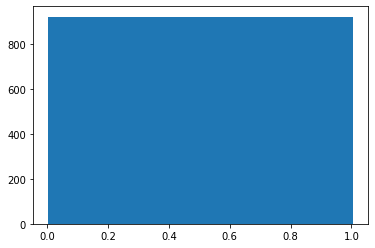

Average value is:  0.5039072
Total Predicted Positive:  0  out of  920
0.0 %
Epoch:  3
Train on 1 samples, validate on 920 samples
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.6814 - val_acc: 1.0000
(920, 1)


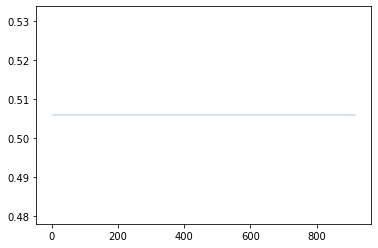

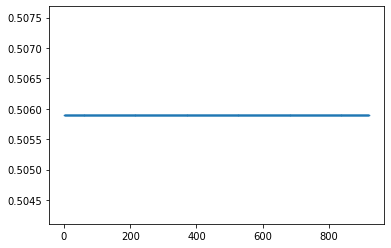

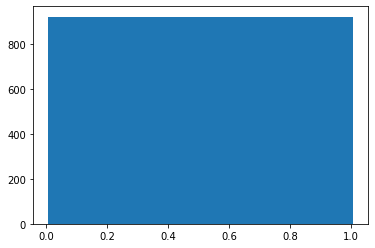

Average value is:  0.50589645
Total Predicted Positive:  0  out of  920
0.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 1
## create the model
modelRNNLSTM1 = 0
modelRNNLSTM1 = Sequential()
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM1.add(Dense(1, activation='sigmoid'))
modelRNNLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM1.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM1.fit(X_train1_flatten, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1_flatten, y_val1),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM1.predict(X_val1_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 7s 35ms/step - loss: 0.6924 - acc: 0.1892 - val_loss: 0.6854 - val_acc: 1.0000
(736, 1)


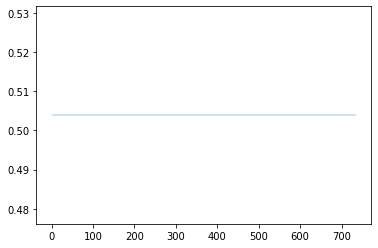

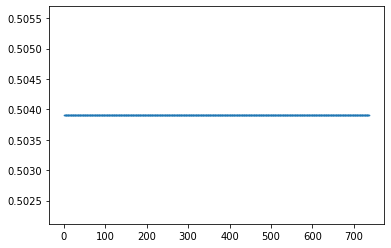

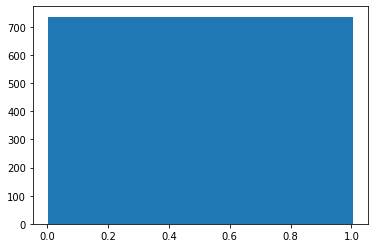

Average value is:  0.50390714
Total Predicted Positive:  736  out of  736
100.0 %
Epoch:  2
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 5s 27ms/step - loss: 0.6846 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 1.0000
(736, 1)


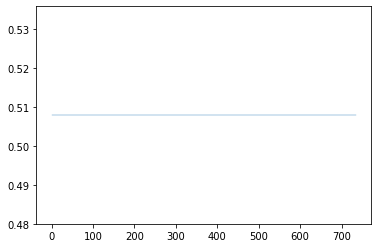

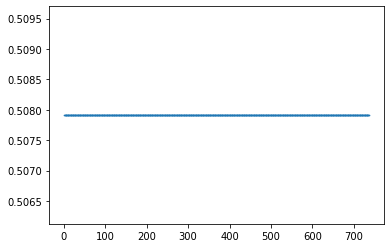

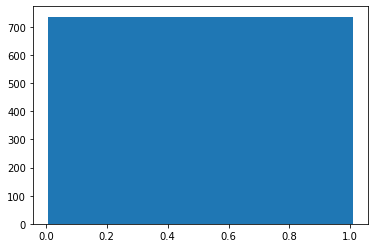

Average value is:  0.50791174
Total Predicted Positive:  736  out of  736
100.0 %
Epoch:  3
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 5s 28ms/step - loss: 0.6767 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 1.0000
(736, 1)


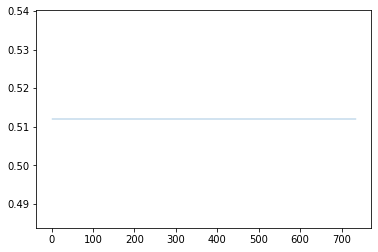

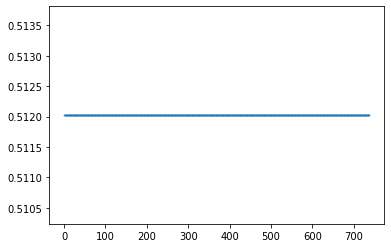

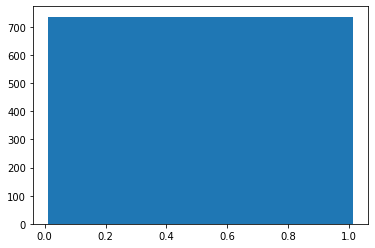

Average value is:  0.512024
Total Predicted Positive:  736  out of  736
100.0 %
Epoch:  4
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 5s 27ms/step - loss: 0.6686 - acc: 1.0000 - val_loss: 0.6612 - val_acc: 1.0000
(736, 1)


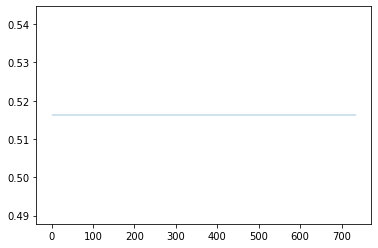

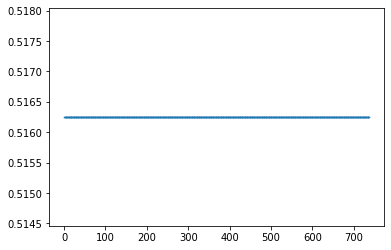

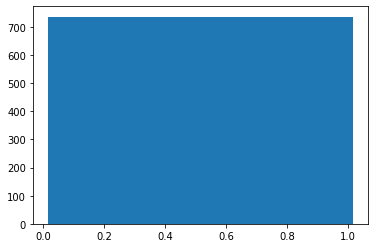

Average value is:  0.51624775
Total Predicted Positive:  736  out of  736
100.0 %
Epoch:  5
Train on 185 samples, validate on 736 samples
Epoch 1/1
185/185 [==============================] - 5s 27ms/step - loss: 0.6604 - acc: 1.0000 - val_loss: 0.6528 - val_acc: 1.0000
(736, 1)


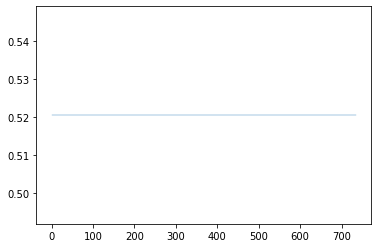

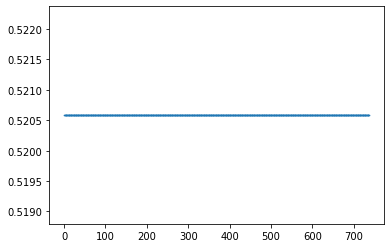

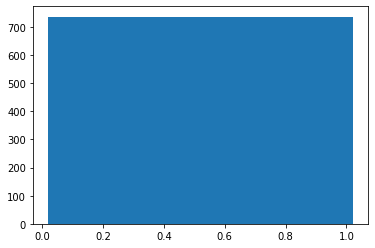

Average value is:  0.5205856
Total Predicted Positive:  736  out of  736
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 2
## create the model
modelRNNLSTM2 = 0
modelRNNLSTM2 = Sequential()
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM2.add(Dense(1, activation='sigmoid'))
modelRNNLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM2.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM2.fit(X_train2_flatten, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2_flatten, y_val2),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM2.predict(X_val2_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_6 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 290s 787ms/step - loss: 0.3841 - acc: 0.9946 - val_loss: 0.1378 - val_acc: 1.0000
(552, 1)


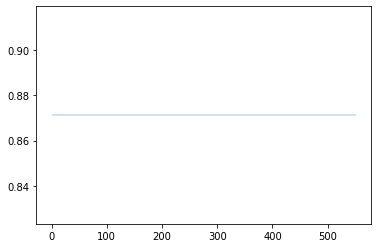

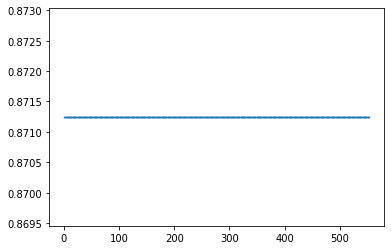

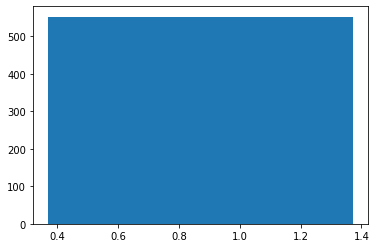

Average value is:  0.8712421
Total Predicted Positive:  552  out of  552
100.0 %
Epoch:  2
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 289s 783ms/step - loss: 0.0938 - acc: 1.0000 - val_loss: 0.0716 - val_acc: 1.0000
(552, 1)


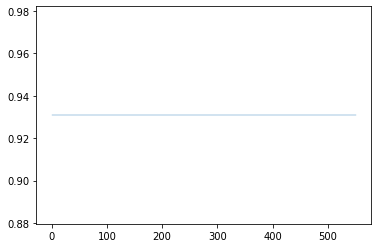

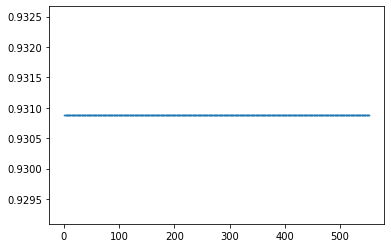

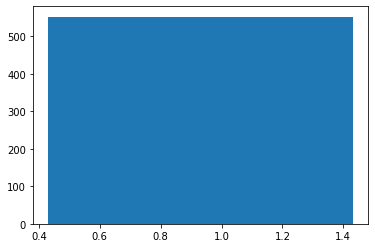

Average value is:  0.9308795
Total Predicted Positive:  552  out of  552
100.0 %
Epoch:  3
Train on 369 samples, validate on 552 samples
Epoch 1/1
369/369 [==============================] - 288s 780ms/step - loss: 0.0599 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
(552, 1)


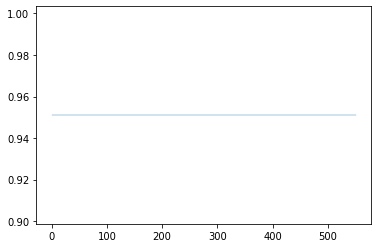

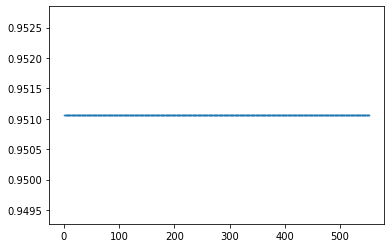

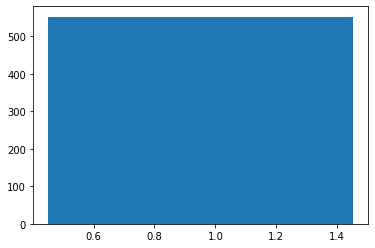

Average value is:  0.9510613
Total Predicted Positive:  0  out of  552
0.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 3
## create the model
modelRNNLSTM3 = 0
modelRNNLSTM3 = Sequential()
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM3.add(Dense(1, activation='sigmoid'))
modelRNNLSTM3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM3.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM3.fit(X_train3_flatten, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3_flatten, y_val3),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM3.predict(X_val3_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_8 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 329s 595ms/step - loss: 0.2919 - acc: 0.9964 - val_loss: 0.0901 - val_acc: 1.0000
(368, 1)


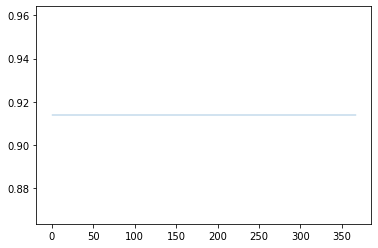

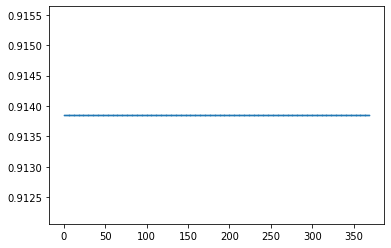

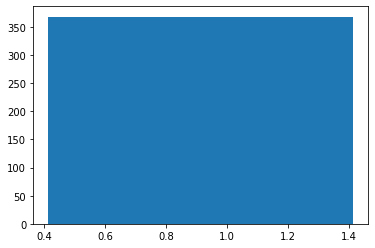

Average value is:  0.91385
Total Predicted Positive:  368  out of  368
100.0 %
Epoch:  2
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 328s 593ms/step - loss: 0.0667 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
(368, 1)


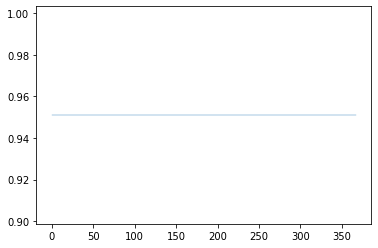

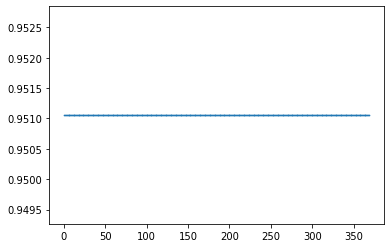

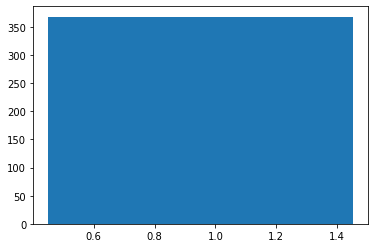

Average value is:  0.95105547
Total Predicted Positive:  0  out of  368
0.0 %
Epoch:  3
Train on 553 samples, validate on 368 samples
Epoch 1/1
553/553 [==============================] - 327s 592ms/step - loss: 0.0408 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 1.0000
(368, 1)


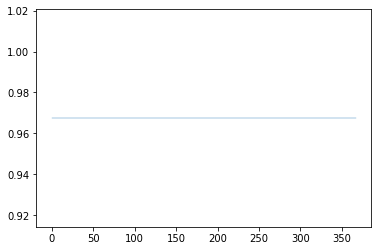

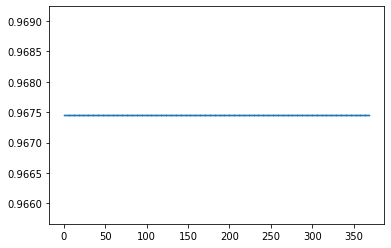

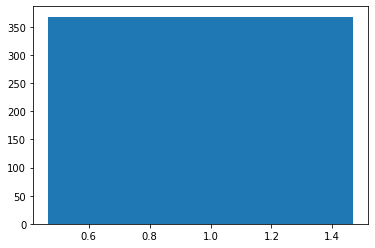

Average value is:  0.96745217
Total Predicted Positive:  368  out of  368
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 4
## create the model
modelRNNLSTM4 = 0
modelRNNLSTM4 = Sequential()
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM4.add(Dense(1, activation='sigmoid'))
modelRNNLSTM4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM4.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM4.fit(X_train4_flatten, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4_flatten, y_val4),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM4.predict(X_val4_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_10 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 370s 501ms/step - loss: 0.2392 - acc: 0.9973 - val_loss: 0.0718 - val_acc: 1.0000
(184, 1)


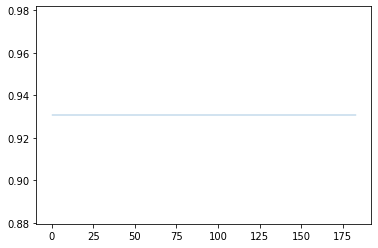

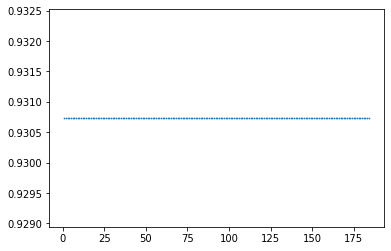

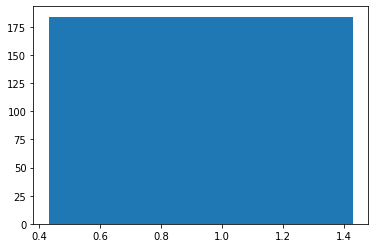

Average value is:  0.9307314
Total Predicted Positive:  184  out of  184
100.0 %
Epoch:  2
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 368s 500ms/step - loss: 0.0518 - acc: 1.0000 - val_loss: 0.0377 - val_acc: 1.0000
(184, 1)


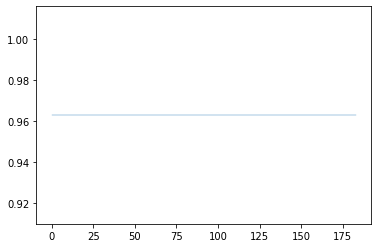

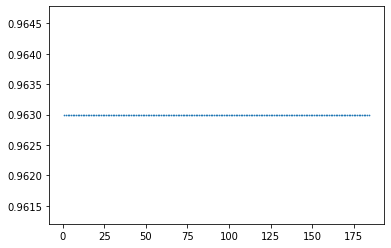

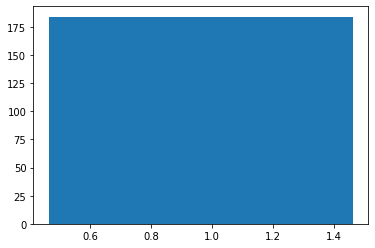

Average value is:  0.9629926
Total Predicted Positive:  0  out of  184
0.0 %
Epoch:  3
Train on 737 samples, validate on 184 samples
Epoch 1/1
737/737 [==============================] - 369s 501ms/step - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 1.0000
(184, 1)


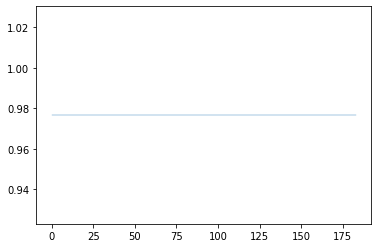

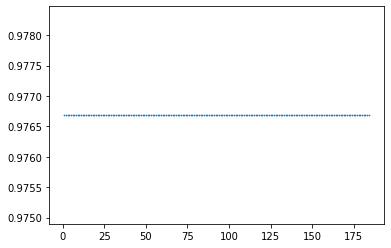

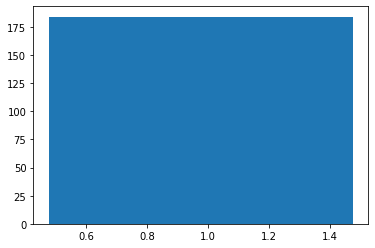

Average value is:  0.97668684
Total Predicted Positive:  184  out of  184
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 5
## create the model
modelRNNLSTM5 = 0
modelRNNLSTM5 = Sequential()
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM5.add(Dense(1, activation='sigmoid'))
modelRNNLSTM5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM5.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM5.fit(X_train5_flatten, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5_flatten, y_val5),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM5.predict(X_val5_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 411s 451ms/step - loss: 0.2061 - acc: 0.9978 - val_loss: 0.0600 - val_acc: 1.0000
(10, 1)


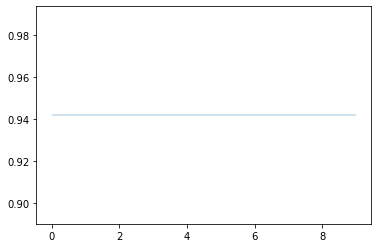

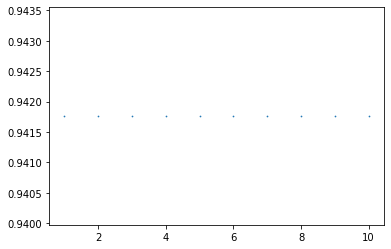

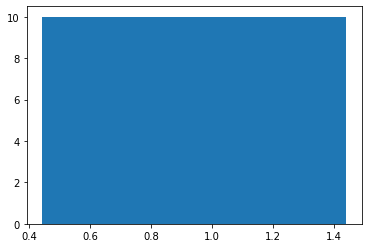

Average value is:  0.9417612
Total Predicted Positive:  10  out of  10
100.0 %
Epoch:  2
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 408s 448ms/step - loss: 0.0422 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 1.0000
(10, 1)


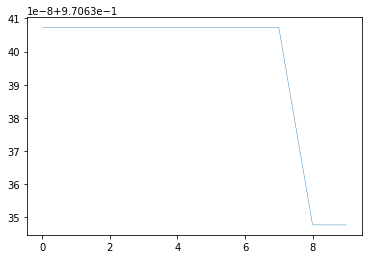

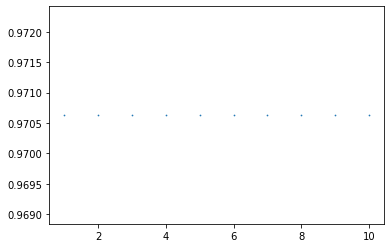

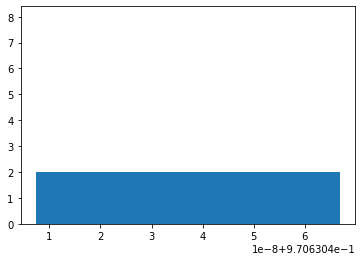

Average value is:  0.97063047
Total Predicted Positive:  0  out of  10
0.0 %
Epoch:  3
Train on 911 samples, validate on 10 samples
Epoch 1/1
911/911 [==============================] - 407s 447ms/step - loss: 0.0231 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 1.0000
(10, 1)


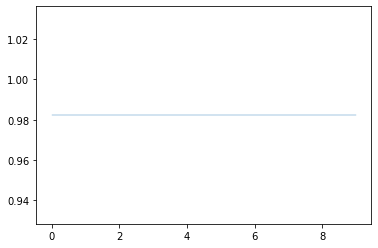

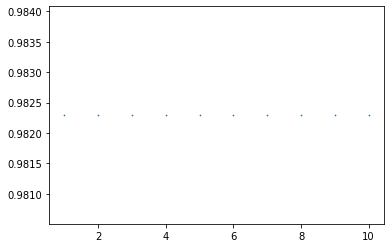

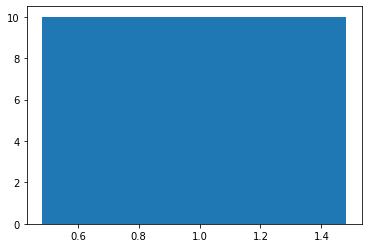

Average value is:  0.98229486
Total Predicted Positive:  0  out of  10
0.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 6
## create the model
modelRNNLSTM6 = 0
modelRNNLSTM6 = Sequential()
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM6.add(Dense(1, activation='sigmoid'))
modelRNNLSTM6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM6.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM6.fit(X_train6_flatten, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6_flatten, y_val6),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM6.predict(X_val6_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_14 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 210s 105s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 1.0000
(919, 1)


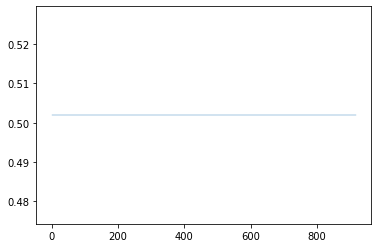

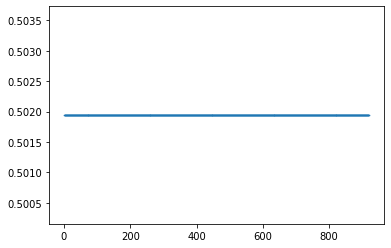

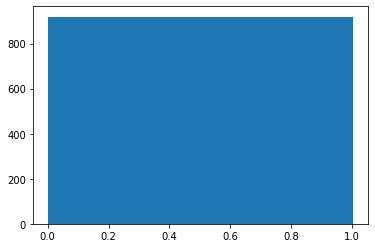

Average value is:  0.50194305
Total Predicted Positive:  0  out of  919
0.0 %
Epoch:  2
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 207s 103s/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
(919, 1)


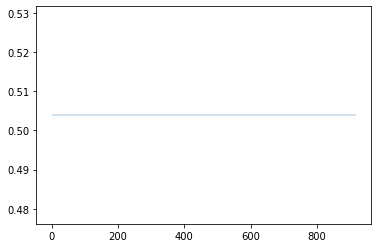

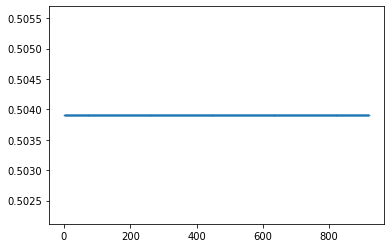

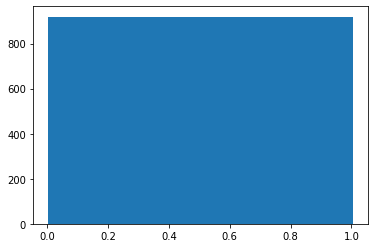

Average value is:  0.5039072
Total Predicted Positive:  0  out of  919
0.0 %
Epoch:  3
Train on 2 samples, validate on 919 samples
Epoch 1/1
2/2 [==============================] - 208s 104s/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.6814 - val_acc: 1.0000
(919, 1)


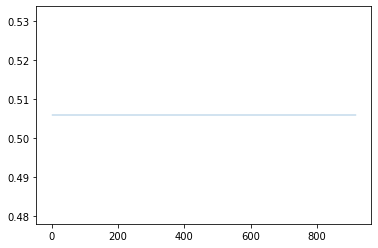

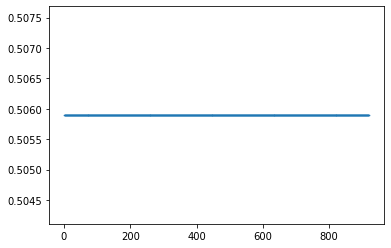

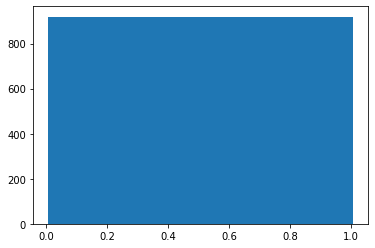

Average value is:  0.50589645
Total Predicted Positive:  0  out of  919
0.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 7
## create the model
modelRNNLSTM7 = 0
modelRNNLSTM7 = Sequential()
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM7.add(Dense(1, activation='sigmoid'))
modelRNNLSTM7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM7.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM7.fit(X_train7_flatten, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7_flatten, y_val7),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM7.predict(X_val7_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1